In [1]:
# imports
import json
import os
import shutil
import sys
from pathlib import Path

import matplotlib as mpl
import numpy as np
import torch
import torch.distributed as dist
from mmcv import VideoReader
from mmengine.config import Config, DictAction
from torch.nn.parallel import DistributedDataParallel
from PIL import ImageDraw, ImageFont

from opentad.cores.test_engine import eval_one_epoch
from opentad.datasets.builder import build_dataloader, build_dataset
from opentad.models import build_detector
from opentad.utils.logger import setup_logger
import cv2

os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '0'

dist.init_process_group("nccl", init_method="env://", rank=0, world_size=1)
torch.cuda.set_device(0)

In [2]:
def load_model(cfg, ckpt_path, logger):
    model = build_detector(cfg.model)
    model.to(0)
    model = DistributedDataParallel(model, device_ids=[0], output_device=0)

    device = f"cuda:0"
    checkpoint = torch.load(ckpt_path, map_location=device)

    use_ema = getattr(cfg.solver, "ema", False)
    if use_ema:
        model.load_state_dict(checkpoint["state_dict_ema"])
        logger.info("Using Model EMA...")
    else:
        model.load_state_dict(checkpoint["state_dict"])
    
    return model

def prepare_input(cfg, logger, video_path, video_dir, subset="testing"):
    new_ann_dict = {}
    print("++++++", cfg.dataset.test.ann_file)
    with open(cfg.dataset.test.ann_file, "r") as f:
        raw_annotation = json.load(f)

    for key in raw_annotation.keys():
        if key != "database":
            new_ann_dict[key] = raw_annotation[key]
    
    # load video metainfo using decord
    reader = VideoReader(video_path)
    duration = reader.frame_cnt / reader.fps
    logger.info(f"Video duration of {video_path}: {duration:.2f}s")
    
    video_key = video_path.split("/")[-1].split(".")[0]
    print("*********************video key:", video_key)
    if video_key in raw_annotation["database"]:
        new_ann_dict["database"] = {video_key: raw_annotation['database'][video_key]}
    else:
        # copy video to video dir
        video_path = Path(video_path)
        new_video_path = Path(video_dir) / video_path.name
        if not new_video_path.exists():
            shutil.copyfile(video_path, new_video_path)
        new_ann_dict["database"] = {video_key: {"subset": subset, "frame": reader.frame_cnt, "duration": duration, "annotations": []}}

    with open("data/charades/annotations/charades_test.json", "w") as f:
        json.dump(new_ann_dict, f)
    
def inference(model, cfg, logger):

    # AMP: automatic mixed precision
    use_amp = getattr(cfg.solver, "amp", False)
    if use_amp:
        logger.info("Using Automatic Mixed Precision...")

    cfg.dataset.test.ann_file = "data/charades/annotations/charades_test.json"

    test_dataset = build_dataset(cfg.dataset.test, default_args=dict(logger=logger))
    test_loader = build_dataloader(
        test_dataset,
        rank=0,
        world_size=1,
        shuffle=False,
        drop_last=False,
        **cfg.solver.test,
    )

    logger.info("Testing Starts...\n")
    eval_one_epoch(
        test_loader,
        model,
        cfg,
        logger,
        0,
        model_ema=None,  # since we have loaded the ema model above
        use_amp=use_amp,
        world_size=1,
        not_eval=True,
    )
    logger.info("Testing Over...\n")
    
    with open(cfg.work_dir + "/result_detection.json", "r") as f:
        results = json.load(f)
    return results

def filter_segments(result, num_concurrent_events=1, thresh=0.05):
    segments = list(result["results"].values())[0]
    processed_result = list(sorted(filter(lambda x: x['score'] > thresh, segments), key=lambda x: x['segment'][0]))
    max = processed_result[-1]['segment'][1]
    for i in range(int(0), int(max)*10 + 1):
        overlapped_segments = list(filter(lambda x: x['segment'][0] <= i/10 and x['segment'][1] >= i/10, processed_result))
        if len(overlapped_segments) > num_concurrent_events:
            # print(f"Overlapped segments at {i}: {overlapped_segments}")
            for segment in overlapped_segments[num_concurrent_events:]:
                processed_result.remove(segment)
    return processed_result

def generate_action_bar(processed_result, action_labels, duration=600, shape=(1920, 50)):
    cmap = mpl.colormaps['magma']
    w, h = shape
    action_bar = np.ones((h, w, 3), dtype=np.float32)
    for i, segment in enumerate(processed_result):
        start = int(segment['segment'][0] / duration * w)
        end = int(segment['segment'][1] / duration * w)
        label = segment['label']
        color = cmap(action_labels.index(label) / len(action_labels))
        # print(f"Segment {i}: {label} from {start}, with color {mpl.colors.to_rgb(color)}")
        action_bar[:, start:end] = mpl.colors.to_rgb(color)
    return (action_bar*255).astype(np.uint8)

def draw_action_timeline(result_segments, gt_segments, video_time, score_thresh=0.3, graph_width=1080, bar_height=40):
    cmap = mpl.colormaps['magma']
    font = ImageFont.truetype("ukai.ttc", 20, encoding="utf-8")
    filtered_result = list(filter(lambda r: r['score'] > score_thresh, result_segments))
    all_labels = list(set([r['label'] for r in filtered_result]).union(set([r['label']for r in gt_segments])))
    time_graph = np.ones((bar_height*(len(all_labels) + 1), graph_width, 3), dtype=np.float32)

    # draw gt time line in the first row
    for i, ann in enumerate(gt_segments):
        start = int(ann['segment'][0] / video_time * graph_width)
        end = int(ann['segment'][1] / video_time * graph_width)
        label = ann['label']
        color = cmap(all_labels.index(label) / len(all_labels))
        time_graph[0+5:bar_height - 5, start:end] = mpl.colors.to_rgb(color)

        cv2.putText(time_graph, str(all_labels.index(label)), ((start + end) // 2, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    for i, segment in enumerate(filtered_result):
        start = int(segment['segment'][0] / video_time * graph_width)
        end = int(segment['segment'][1] / video_time * graph_width)
        label = segment['label']
        label_idx = all_labels.index(label)
        color = cmap(all_labels.index(label) / len(all_labels))
        time_graph[(label_idx+1)*bar_height + 5:(label_idx+2)*bar_height - 5, start:end] = mpl.colors.to_rgb(color)
        cv2.putText(time_graph, "{:.2f}".format(segment['score']), ((start + end) // 2, (label_idx+1)*bar_height + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0.5, 0), 1)

    pimg = Image.fromarray((time_graph * 255).astype(np.uint8))
    for i, label in enumerate(all_labels):
        color = cmap(i / len(all_labels))
        color_int = tuple(map(lambda x: int(x*255), mpl.colors.to_rgb(color)))

        draw = ImageDraw.Draw(pimg)
        draw.text((0, (i+1)*bar_height), str(i) + ":" + label, font=font, fill=(0, 0, 255))
    time_graph = np.array(pimg)

    return time_graph

## 测试B11视频

In [3]:
video_dir = "data/lean_analysis/raw_data/video/"
configfile = "configs/adatad/lean_analysis/e2e_lean_videomae_b_768x1_224_adapter.py"
checkpoint_path = "exps/lean/adatad/e2e_actionformer_videomae_b_768x1_224_adapter/gpu2_id0/checkpoint/epoch_99.pth"
cfg = Config.fromfile(configfile)
logger = setup_logger("Test", save_dir=cfg.work_dir, distributed_rank=0)
logger.info(f"Using torch version: {torch.__version__}, CUDA version: {torch.version.cuda}")

model = load_model(cfg, checkpoint_path, logger)
# logger.info(f"Config: \n{cfg.pretty_text}")

2024-08-07 17:43:44 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
ViT's param: 86227200, Adapter's params: 4004364, ratio: 4.6%
Loads checkpoint by local backend from path: pretrained/vit-base-p16_videomae-k400-pre_16x4x1_kinetics-400_20221013-860a3cd3.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: cls_head.fc_cls.weight, cls_head.fc_cls.bias

missing keys in source state_dict: backbone.pos_embed, backbone.blocks.0.adapter.gamma, backbone.blocks.0.adapter.dwconv.weight, backbone.blocks.0.adapter.dwconv.bias, backbone.blocks.0.adapter.conv.weight, backbone.blocks.0.adapter.conv.bias, backbone.blocks.0.adapter.down_proj.weight, backbone.blocks.0.adapter.down_proj.bias, backbone.blocks.0.adapter.up_proj.weight, backbone.blocks.0.adapter.up_proj.bias, backbone.blocks.1.adapter.gamma, backbone.blocks.1.adapter.dwconv.weight, backbone.blocks.1.adapter.dwconv.bias, backbone.blocks.1.adapter.conv.weight, backbone.blocks.1.adapte

In [4]:
# video_file = "data/lean_analysis/raw_data/record2_20240619094017_000006.mp4"

# model = load_model(cfg, checkpoint_path, logger)
# prepare_input(cfg, logger, video_file, video_dir)
# result = inference(model, cfg, logger)

In [5]:
from collections import defaultdict, Counter

import json

ground_truth_path = "data/lean_analysis/annotations/lean_analysis_anno.json"

with open(ground_truth_path) as f:
    gt_data = json.load(f)

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[('旋转产品', 386),
 ('检查产品', 142),
 ('取扫码枪并扫码', 115),
 ('检查外观', 62),
 ('上料', 56),
 ('产品推入设备', 55),
 ('从设备取产品', 54),
 ('装盖子', 53),
 ('取螺丝并打螺丝', 53),
 ('将产品放入货柜', 53),
 ('取透明罩对比产品放回透明罩', 47),
 ('拆外壳', 1)]

In [6]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(20))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    if gt_rec['subset'] != "testing":
        continue
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:40]

In [8]:
from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype("ukai.ttc", 60, encoding="utf-8")


for key, _ in example_videos:
    video_file = f"{video_dir}/{key}.mp4"
    
    prepare_input(cfg, logger, video_file, video_dir, "testing")
    result = inference(model, cfg, logger)
    
    processed_result = filter_segments(result)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    # action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    # gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    action_timeline = draw_action_timeline(list(result['results'].values())[0], gt_result, video.frame_cnt / video.fps, 0.2, video.width, 40)
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_{'-'.join(key.split('/'))}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + action_timeline.shape[0]))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, action_timeline])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        pimg = Image.fromarray(new_frame)
        draw = ImageDraw.Draw(pimg)
        draw.text((100, 220), f"GT: {gt_label}", font=font, fill=(0, 0, 255), stroke_width=2)
        draw.text((100, 260), f"Pred: {pred_label}", font=font, fill=(0, 0, 255), stroke_width=2)
        # cv2.putText(new_frame, f"GT: {gt_label}", (10, video.height // 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        # cv2.putText(new_frame, f"Pred: {pred_label}", (10, video.height // 4 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        new_frame = np.array(pimg)
        
        progress = int(i / video.frame_cnt * video.width)
        cv2.line(new_frame, (progress, new_frame.shape[0] - action_timeline.shape[0]), (progress, new_frame.shape[0]), (255, 255, 0), 2)
        
        writer.write(new_frame)
    writer.release()

2024-08-07 17:47:35 Test INFO: Video duration of data/lean_analysis/raw_data/video//record2_20240619094017_000008.mp4: 600.13s
*********************video key: record2_20240619094017_000008
2024-08-07 17:47:35 Test INFO: Using Automatic Mixed Precision...
2024-08-07 17:47:35 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-08-07 17:47:35 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

08/07 17:47:36 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 17:47:36 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/07 17:47:36 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 17:47:36 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:07<00:00, 11.33s/it]


2024-08-07 17:48:44 Test INFO: Testing Over...

2024-08-07 17:57:14 Test INFO: Video duration of data/lean_analysis/raw_data/video//record2_20240619094017_000034.mp4: 600.13s
*********************video key: record2_20240619094017_000034
2024-08-07 17:57:14 Test INFO: Using Automatic Mixed Precision...
2024-08-07 17:57:14 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-08-07 17:57:14 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

08/07 17:57:14 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 17:57:14 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 17:57:14 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/07 17:57:14 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:08<00:00, 11.42s/it]


2024-08-07 17:58:23 Test INFO: Testing Over...

2024-08-07 18:06:56 Test INFO: Video duration of data/lean_analysis/raw_data/video//record2_20240619094017_000035.mp4: 437.87s
*********************video key: record2_20240619094017_000035
2024-08-07 18:06:56 Test INFO: Using Automatic Mixed Precision...
2024-08-07 18:06:56 Test INFO: testing subset: 1 videos, truncated as 8 windows.
2024-08-07 18:06:56 Test INFO: Testing Starts...



  0%|          | 0/4 [00:00<?, ?it/s]

08/07 18:06:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 18:06:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 18:06:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/07 18:06:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 4/4 [00:45<00:00, 11.29s/it]


2024-08-07 18:07:41 Test INFO: Testing Over...

2024-08-07 18:13:56 Test INFO: Video duration of data/lean_analysis/raw_data/video//record2_20240619094017_000028.mp4: 600.13s
*********************video key: record2_20240619094017_000028
2024-08-07 18:13:56 Test INFO: Using Automatic Mixed Precision...
2024-08-07 18:13:56 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-08-07 18:13:56 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

08/07 18:13:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 18:13:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
08/07 18:13:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/07 18:13:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:08<00:00, 11.35s/it]


2024-08-07 18:15:05 Test INFO: Testing Over...



## 查看Charades Testing结果数据

In [3]:
import json

result_path = "exps/charades/adatad/e2e_actionformer_videomae_l_512x1_160_adapter/gpu2_id0/result_detection.json"
ground_truth_path = "data/charades/annotations/charades.fix.json"

with open(result_path) as f:
    res_data = json.load(f)
    
with open(ground_truth_path) as f:
    gt_data = json.load(f)

In [4]:
from collections import defaultdict, Counter

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[('Walking through a doorway', 1079),
 ('Someone is standing up from somewhere', 1022),
 ('Sitting in a chair', 913),
 ('Holding some food', 864),
 ('Drinking from a cup/glass/bottle', 847),
 ('Holding a cup/glass/bottle of something', 821),
 ('Someone is smiling', 780),
 ('Holding a phone/camera', 741),
 ('Someone is going from standing to sitting', 728),
 ('Someone is eating something', 694),
 ('Putting something on a table', 669),
 ('Holding a dish', 630),
 ('Opening a door', 619),
 ('Taking food from somewhere', 547),
 ('Holding a bag', 527),
 ('Sitting at a table', 522),
 ('Putting clothes somewhere', 515),
 ('Holding some clothes', 506),
 ('Playing with a phone/camera', 485),
 ('Closing a door', 473)]

In [5]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(20))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:20]

In [6]:
model = load_model(cfg, checkpoint_path, logger)

NameError: name 'cfg' is not defined

In [19]:
for key, _ in example_videos:
    video_file = f"data/charades/raw_data/Charades_v1_480_30fps/{key}.mp4"
    
    prepare_input(cfg, logger, video_file, video_dir)
    result = inference(model, cfg, logger)
    
    processed_result = filter_segments(result)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_{key}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + 40))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, gt_action_bar, action_bar])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        cv2.putText(new_frame, f"GT: {gt_label}", (10, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(new_frame, f"Pred: {pred_label}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        writer.write(new_frame)
    writer.release()
    
    

2024-07-10 23:13:54 Test INFO: Video duration of data/charades/raw_data/Charades_v1_480_30fps/AAQHJ.mp4: 30.87s
*********************video key: AAQHJ
2024-07-10 23:13:54 Test INFO: Using Automatic Mixed Precision...
2024-07-10 23:13:54 Test INFO: testing subset: 1 videos, truncated as 1 windows.
2024-07-10 23:13:54 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:13:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:13:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

2024-07-10 23:13:55 Test INFO: Testing Over...



Segment 0: Sitting on the floor from 31, with color (0.347636, 0.082946, 0.494121)
Segment 1: Someone is standing up from somewhere from 241, with color (0.278493, 0.061978, 0.46919)
Segment 0: Holding a pillow from 8, with color (0.562866, 0.165368, 0.504692)
Segment 1: Someone is eating something from 44, with color (0.913354, 0.330052, 0.382563)
Segment 2: Someone is standing up from somewhere from 79, with color (0.278493, 0.061978, 0.46919)
Segment 3: Holding some food from 158, with color (0.639216, 0.189921, 0.49415)
Segment 4: Taking a cup/glass/bottle from somewhere from 70, with color (0.021692, 0.01832, 0.09261)
Segment 5: Drinking from a cup/glass/bottle from 155, with color (0.997228, 0.747981, 0.516859)
Segment 6: Someone is going from standing to sitting from 30, with color (0.123833, 0.067295, 0.295879)
Segment 7: Sitting in a chair from 59, with color (0.990871, 0.572706, 0.398714)
Segment 8: Holding a dish from 50, with color (0.716387, 0.214982, 0.47529)
Segment 9: P

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:13:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:13:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


2024-07-10 23:13:58 Test INFO: Testing Over...

Segment 0: Walking through a doorway from 7, with color (0.001462, 0.000466, 0.013866)
Segment 1: Someone is undressing from 115, with color (0.341482, 0.080564, 0.492631)
Segment 2: Putting a phone/camera somewhere from 350, with color (0.944006, 0.377643, 0.365136)
Segment 0: Watching something/someone/themselves in a mirror from 243, with color (0.123833, 0.067295, 0.295879)
Segment 1: Closing a door from 28, with color (0.767398, 0.233705, 0.457755)
Segment 2: Opening a door from 6, with color (0.994738, 0.62435, 0.427397)
Segment 3: Someone is going from standing to sitting from 79, with color (0.232077, 0.059889, 0.437695)
Segment 4: Someone is undressing from 117, with color (0.341482, 0.080564, 0.492631)
Segment 5: Someone is standing up from somewhere from 395, with color (0.550287, 0.161158, 0.505719)
Segment 6: Sitting in a chair from 92, with color (0.99317, 0.870024, 0.626189)
Segment 7: Taking a phone/camera from somewhere f

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:00 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


2024-07-10 23:14:01 Test INFO: Testing Over...

Segment 0: Pouring something into a cup/glass/bottle from 2, with color (0.716387, 0.214982, 0.47529)
Segment 1: Someone is going from standing to sitting from 100, with color (0.316654, 0.07169, 0.48538)
Segment 2: Taking food from somewhere from 164, with color (0.232077, 0.059889, 0.437695)
Segment 0: Eating a sandwich from 173, with color (0.146785, 0.068738, 0.334011)
Segment 1: Someone is eating something from 165, with color (0.9867, 0.535582, 0.38221)
Segment 2: Sitting at a table from 108, with color (0.967671, 0.439703, 0.35981)
Segment 3: Taking food from somewhere from 62, with color (0.232077, 0.059889, 0.437695)
Segment 4: Putting a cup/glass/bottle somewhere from 102, with color (0.997351, 0.719089, 0.493755)
Segment 5: Someone is going from standing to sitting from 100, with color (0.316654, 0.07169, 0.48538)
Segment 6: Sitting in a chair from 111, with color (0.994738, 0.62435, 0.427397)
Segment 7: Taking a sandwich from 

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:04 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:04 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


2024-07-10 23:14:05 Test INFO: Testing Over...

Segment 0: Holding some food from 0, with color (0.840636, 0.268953, 0.424666)
Segment 0: Someone is standing up from somewhere from 189, with color (0.581819, 0.171596, 0.502777)
Segment 1: Sitting in a chair from 0, with color (0.982279, 0.505851, 0.371874)
Segment 2: Putting some food somewhere from 138, with color (0.995932, 0.805527, 0.566202)
Segment 3: Lying on a bed from 283, with color (0.754737, 0.228772, 0.462509)
Segment 4: Eating a sandwich from 0, with color (0.159018, 0.068354, 0.352688)
Segment 5: Holding some food from 0, with color (0.840636, 0.268953, 0.424666)
Segment 6: Someone is eating something from 0, with color (0.958464, 0.411324, 0.360014)
Segment 7: Putting a dish/es somewhere from 166, with color (0.991688, 0.898627, 0.654202)
Segment 8: Taking food from somewhere from 0, with color (0.335308, 0.078236, 0.491024)
Segment 9: Someone is going from standing to sitting from 294, with color (0.245543, 0.059352, 0.

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:06 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:06 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


2024-07-10 23:14:08 Test INFO: Testing Over...

Segment 0: Drinking from a cup/glass/bottle from 0, with color (0.992089, 0.89147, 0.647116)
Segment 1: Holding a phone/camera from 190, with color (0.716387, 0.214982, 0.47529)
Segment 0: Playing with a phone/camera from 264, with color (0.531507, 0.154739, 0.506895)
Segment 1: Opening a door from 390, with color (0.997077, 0.690088, 0.471811)
Segment 2: Someone is going from standing to sitting from 170, with color (0.359898, 0.087831, 0.496778)
Segment 3: Someone is standing up from somewhere from 294, with color (0.620005, 0.18384, 0.497524)
Segment 4: Closing a door from 18, with color (0.944006, 0.377643, 0.365136)
Segment 5: Putting something on a table from 129, with color (0.97669, 0.476226, 0.364466)
Segment 6: Lying on the floor from 227, with color (0.001462, 0.000466, 0.013866)
Segment 7: Walking through a doorway from 405, with color (0.171713, 0.067305, 0.370771)
Segment 8: Grasping onto a doorknob from 0, with color (0.445

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:09 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:09 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


2024-07-10 23:14:10 Test INFO: Testing Over...

Segment 0: Someone is going from standing to sitting from 0, with color (0.232077, 0.059889, 0.437695)
Segment 1: Someone is eating something from 139, with color (0.944006, 0.377643, 0.365136)
Segment 2: Putting a cup/glass/bottle somewhere from 422, with color (0.994738, 0.62435, 0.427397)
Segment 0: Drinking from a cup/glass/bottle from 296, with color (0.997228, 0.747981, 0.516859)
Segment 1: Sitting in a chair from 44, with color (0.981, 0.498428, 0.369734)
Segment 2: Sitting at a table from 50, with color (0.868793, 0.287728, 0.409303)
Segment 3: Someone is going from standing to sitting from 28, with color (0.232077, 0.059889, 0.437695)
Segment 4: Someone is smiling from 274, with color (0.445163, 0.122724, 0.506901)
Segment 5: Holding a cup/glass/bottle of something from 287, with color (0.001462, 0.000466, 0.013866)
Segment 6: Holding a sandwich from 52, with color (0.550287, 0.161158, 0.505719)
Segment 7: Putting something on a 

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:13 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:13 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


2024-07-10 23:14:14 Test INFO: Testing Over...

Segment 0: Opening a closet/cabinet from 0, with color (0.316654, 0.07169, 0.48538)
Segment 1: Someone is going from standing to sitting from 175, with color (0.113094, 0.065492, 0.276784)
Segment 2: Putting a dish/es somewhere from 277, with color (0.99244, 0.88433, 0.640099)
Segment 3: Putting something on a table from 400, with color (0.512831, 0.148179, 0.507648)
Segment 0: Holding some food from 207, with color (0.816914, 0.255895, 0.436461)
Segment 1: Holding a cup/glass/bottle of something from 296, with color (0.001462, 0.000466, 0.013866)
Segment 2: Sitting in a chair from 191, with color (0.996096, 0.653659, 0.446213)
Segment 3: Someone is going from standing to sitting from 177, with color (0.113094, 0.065492, 0.276784)
Segment 4: Holding a dish from 207, with color (0.716387, 0.214982, 0.47529)
Segment 5: Grasping onto a doorknob from 0, with color (0.211718, 0.061992, 0.418647)
Segment 6: Sitting at a table from 188, with col

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


2024-07-10 23:14:17 Test INFO: Testing Over...

Segment 0: Someone is going from standing to sitting from 0, with color (0.359898, 0.087831, 0.496778)
Segment 1: Taking a cup/glass/bottle from somewhere from 134, with color (0.171713, 0.067305, 0.370771)
Segment 2: Putting something on a table from 208, with color (0.716387, 0.214982, 0.47529)
Segment 0: Eating a sandwich from 80, with color (0.265447, 0.060237, 0.46184)
Segment 1: Opening a box from 122, with color (0.001462, 0.000466, 0.013866)
Segment 2: Someone is going from standing to sitting from 24, with color (0.359898, 0.087831, 0.496778)
Segment 3: Sitting at a table from 0, with color (0.944006, 0.377643, 0.365136)
Segment 4: Someone is eating something from 170, with color (0.97669, 0.476226, 0.364466)
Segment 5: Someone is standing up from somewhere from 156, with color (0.620005, 0.18384, 0.497524)
Segment 6: Pouring something into a cup/glass/bottle from 50, with color (0.804752, 0.249911, 0.442102)
Segment 7: Closing a

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:19 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:19 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

2024-07-10 23:14:20 Test INFO: Testing Over...



Segment 0: Walking through a doorway from 0, with color (0.060949, 0.044794, 0.176129)
Segment 1: Sitting in a chair from 57, with color (0.846416, 0.272473, 0.421631)
Segment 0: Making a sandwich from 113, with color (0.944006, 0.377643, 0.365136)
Segment 1: Someone is going from standing to sitting from 48, with color (0.445163, 0.122724, 0.506901)
Segment 2: Someone is standing up from somewhere from 227, with color (0.994524, 0.841387, 0.598983)
Segment 3: Putting a dish/es somewhere from 45, with color (0.997077, 0.690088, 0.471811)
Segment 4: Sitting at a table from 70, with color (0.316654, 0.07169, 0.48538)
Segment 5: Holding some food from 93, with color (0.171713, 0.067305, 0.370771)
Segment 6: Holding a dish from 0, with color (0.57549, 0.16953, 0.503466)
Segment 7: Someone is smiling from 235, with color (0.716387, 0.214982, 0.47529)
Segment 8: Walking through a doorway from 12, with color (0.060949, 0.044794, 0.176129)
Segment 9: Sitting in a chair from 81, with color (0.8

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:22 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:22 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


2024-07-10 23:14:23 Test INFO: Testing Over...

Segment 0: Putting something on a table from 0, with color (0.060949, 0.044794, 0.176129)
Segment 1: Someone is eating something from 85, with color (0.445163, 0.122724, 0.506901)
Segment 2: Putting a cup/glass/bottle somewhere from 427, with color (0.944006, 0.377643, 0.365136)
Segment 0: Holding a broom from 21, with color (0.997077, 0.690088, 0.471811)
Segment 1: Someone is eating something from 89, with color (0.445163, 0.122724, 0.506901)
Segment 2: Someone is going from standing to sitting from 57, with color (0.57549, 0.16953, 0.503466)
Segment 3: Someone is standing up from somewhere from 0, with color (0.994524, 0.841387, 0.598983)
Segment 4: Putting something on a table from 0, with color (0.060949, 0.044794, 0.176129)
Segment 5: Sitting in a chair from 63, with color (0.846416, 0.272473, 0.421631)
Segment 6: Drinking from a cup/glass/bottle from 450, with color (0.9867, 0.535582, 0.38221)
Segment 7: Taking a cup/glass/bottle fr

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:24 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:24 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


2024-07-10 23:14:25 Test INFO: Testing Over...

Segment 0: Someone is running somewhere from 4, with color (0.284951, 0.063168, 0.472451)
Segment 1: Someone is standing up from somewhere from 168, with color (0.993866, 0.855711, 0.612482)
Segment 0: Holding some food from 21, with color (0.402548, 0.10542, 0.503386)
Segment 1: Sitting at a table from 15, with color (0.52527, 0.152569, 0.507192)
Segment 2: Someone is eating something from 52, with color (0.652056, 0.193986, 0.491611)
Segment 3: Someone is going from standing to sitting from 15, with color (0.773695, 0.236249, 0.455289)
Segment 4: Someone is standing up from somewhere from 175, with color (0.993866, 0.855711, 0.612482)
Segment 5: Putting something on a table from 140, with color (0.05232, 0.039407, 0.158841)
Segment 6: Taking food from somewhere from 0, with color (0.889731, 0.305079, 0.397002)
Segment 7: Putting some food somewhere from 129, with color (0.997325, 0.711848, 0.488154)
Segment 8: Watching a laptop or somet

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:26 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:26 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

2024-07-10 23:14:27 Test INFO: Testing Over...



Segment 0: Walking through a doorway from 0, with color (0.19146, 0.064818, 0.396152)
Segment 1: Someone is going from standing to sitting from 55, with color (0.384299, 0.097855, 0.501002)
Segment 2: Drinking from a cup/glass/bottle from 111, with color (0.996727, 0.776795, 0.541039)
Segment 0: Drinking from a cup/glass/bottle from 148, with color (0.996727, 0.776795, 0.541039)
Segment 1: Sitting in a chair from 53, with color (0.989363, 0.557873, 0.391671)
Segment 2: Someone is going from standing to sitting from 0, with color (0.384299, 0.097855, 0.501002)
Segment 3: Drinking from a cup/glass/bottle from 164, with color (0.996727, 0.776795, 0.541039)
Segment 4: Sitting at a table from 83, with color (0.925937, 0.346844, 0.374959)
Segment 5: Someone is eating something from 116, with color (0.96968, 0.446936, 0.360311)
Segment 6: Eating a sandwich from 116, with color (0.291366, 0.064553, 0.475462)
Segment 7: Taking a cup/glass/bottle from somewhere from 124, with color (0.102815, 0.

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:29 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:29 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


2024-07-10 23:14:30 Test INFO: Testing Over...

Segment 0: Holding a cup/glass/bottle of something from 0, with color (0.232077, 0.059889, 0.437695)
Segment 0: Drinking from a cup/glass/bottle from 0, with color (0.078815, 0.054184, 0.211667)
Segment 1: Taking food from somewhere from 211, with color (0.868793, 0.287728, 0.409303)
Segment 2: Sitting in a chair from 0, with color (0.994738, 0.62435, 0.427397)
Segment 3: Holding a bag from 240, with color (0.99568, 0.812706, 0.572645)
Segment 4: Sitting at a table from 0, with color (0.716387, 0.214982, 0.47529)
Segment 5: Holding a dish from 0, with color (0.550287, 0.161158, 0.505719)
Segment 6: Putting something on a table from 63, with color (0.390384, 0.100379, 0.501864)
Segment 7: Holding some food from 232, with color (0.967671, 0.439703, 0.35981)
Segment 8: Taking a bag from somewhere from 232, with color (0.001462, 0.000466, 0.013866)
Segment 9: Holding a cup/glass/bottle of something from 0, with color (0.232077, 0.059889, 0.43

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:31 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:31 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

2024-07-10 23:14:33 Test INFO: Testing Over...



Segment 0: Walking through a doorway from 0, with color (0.159018, 0.068354, 0.352688)
Segment 1: Walking through a doorway from 94, with color (0.159018, 0.068354, 0.352688)
Segment 2: Someone is going from standing to sitting from 255, with color (0.335308, 0.078236, 0.491024)
Segment 3: Taking food from somewhere from 398, with color (0.245543, 0.059352, 0.448436)
Segment 0: Holding a shoe/shoes from 139, with color (0.414709, 0.110431, 0.504662)
Segment 1: Turning on a light from 15, with color (0.001462, 0.000466, 0.013866)
Segment 2: Someone is eating something from 410, with color (0.958464, 0.411324, 0.360014)
Segment 3: Drinking from a cup/glass/bottle from 276, with color (0.995932, 0.805527, 0.566202)
Segment 4: Putting shoes somewhere from 153, with color (0.581819, 0.171596, 0.502777)
Segment 5: Holding some food from 401, with color (0.908884, 0.324755, 0.385308)
Segment 6: Someone is going from standing to sitting from 252, with color (0.335308, 0.078236, 0.491024)
Segme

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:36 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:36 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

2024-07-10 23:14:38 Test INFO: Testing Over...



Segment 0: Holding some food from 0, with color (0.840636, 0.268953, 0.424666)
Segment 0: Drinking from a cup/glass/bottle from 0, with color (0.997254, 0.704611, 0.482635)
Segment 1: Holding a cup/glass/bottle of something from 0, with color (0.001462, 0.000466, 0.013866)
Segment 2: Pouring something into a cup/glass/bottle from 198, with color (0.671349, 0.200133, 0.487358)
Segment 3: Someone is going from standing to sitting from 153, with color (0.414709, 0.110431, 0.504662)
Segment 4: Taking a dish/es from somewhere from 192, with color (0.500438, 0.143719, 0.50792)
Segment 5: Putting a dish/es somewhere from 170, with color (0.991688, 0.898627, 0.654202)
Segment 6: Holding a dish from 181, with color (0.908884, 0.324755, 0.385308)
Segment 7: Taking a towel/s from somewhere from 0, with color (0.083446, 0.056225, 0.220755)
Segment 8: Taking some clothes from somewhere from 0, with color (0.159018, 0.068354, 0.352688)
Segment 9: Holding a towel/s from 17, with color (0.754737, 0.22

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:41 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:41 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

2024-07-10 23:14:43 Test INFO: Testing Over...



Segment 0: Sitting at a table from 0, with color (0.445163, 0.122724, 0.506901)
Segment 0: Drinking from a cup/glass/bottle from 282, with color (0.9867, 0.535582, 0.38221)
Segment 1: Someone is eating something from 117, with color (0.716387, 0.214982, 0.47529)
Segment 2: Watching a laptop or something on a laptop from 18, with color (0.997077, 0.690088, 0.471811)
Segment 3: Someone is going from standing to sitting from 0, with color (0.57549, 0.16953, 0.503466)
Segment 4: Sitting at a table from 34, with color (0.445163, 0.122724, 0.506901)
Segment 5: Putting something on a table from 310, with color (0.060949, 0.044794, 0.176129)
Segment 6: Sitting in a chair from 25, with color (0.846416, 0.272473, 0.421631)
Segment 7: Someone is standing up from somewhere from 361, with color (0.994524, 0.841387, 0.598983)
Segment 8: Taking a cup/glass/bottle from somewhere from 270, with color (0.171713, 0.067305, 0.370771)
Segment 9: Holding some food from 87, with color (0.316654, 0.07169, 0.4

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:45 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:45 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

2024-07-10 23:14:47 Test INFO: Testing Over...



Segment 0: Walking through a doorway from 4, with color (0.05232, 0.039407, 0.158841)
Segment 1: Someone is eating something from 103, with color (0.990138, 0.565296, 0.395122)
Segment 2: Putting something on a table from 256, with color (0.652056, 0.193986, 0.491611)
Segment 3: Someone is standing up from somewhere from 388, with color (0.52527, 0.152569, 0.507192)
Segment 0: Drinking from a cup/glass/bottle from 145, with color (0.997325, 0.711848, 0.488154)
Segment 1: Someone is going from standing to sitting from 43, with color (0.152839, 0.068637, 0.343404)
Segment 2: Someone is standing up from somewhere from 0, with color (0.52527, 0.152569, 0.507192)
Segment 3: Someone is eating something from 84, with color (0.990138, 0.565296, 0.395122)
Segment 4: Sitting on sofa/couch from 74, with color (0.993866, 0.855711, 0.612482)
Segment 5: Taking food from somewhere from 122, with color (0.284951, 0.063168, 0.472451)
Segment 6: Putting something on a table from 262, with color (0.65205

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


2024-07-10 23:14:51 Test INFO: Testing Over...

Segment 0: Walking through a doorway from 32, with color (0.102815, 0.06301, 0.257854)
Segment 1: Putting something on a table from 159, with color (0.852126, 0.276106, 0.418573)
Segment 2: Sitting on sofa/couch from 266, with color (0.99244, 0.88433, 0.640099)
Segment 0: Someone is standing up from somewhere from 4, with color (0.664915, 0.198075, 0.488836)
Segment 1: Watching television from 101, with color (0.99658, 0.668256, 0.456192)
Segment 2: Someone is going from standing to sitting from 263, with color (0.384299, 0.097855, 0.501002)
Segment 3: Closing a door from 88, with color (0.761077, 0.231214, 0.460162)
Segment 4: Holding some clothes from 193, with color (0.19146, 0.064818, 0.396152)
Segment 5: Walking through a doorway from 303, with color (0.102815, 0.06301, 0.257854)
Segment 6: Putting clothes somewhere from 190, with color (0.001462, 0.000466, 0.013866)
Segment 7: Someone is going from standing to sitting from 207, with

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


2024-07-10 23:14:55 Test INFO: Testing Over...

Segment 0: Someone is going from standing to sitting from 0, with color (0.232077, 0.059889, 0.437695)
Segment 1: Putting something on a table from 80, with color (0.658483, 0.196027, 0.490253)
Segment 2: Someone is standing up from somewhere from 378, with color (0.550287, 0.161158, 0.505719)
Segment 0: Putting a cup/glass/bottle somewhere from 69, with color (0.994738, 0.62435, 0.427397)
Segment 1: Someone is going from standing to sitting from 0, with color (0.232077, 0.059889, 0.437695)
Segment 2: Someone is standing up from somewhere from 372, with color (0.550287, 0.161158, 0.505719)
Segment 3: Drinking from a cup/glass/bottle from 0, with color (0.997228, 0.747981, 0.516859)
Segment 4: Someone is smiling from 101, with color (0.445163, 0.122724, 0.506901)
Segment 5: Holding a cup/glass/bottle of something from 0, with color (0.001462, 0.000466, 0.013866)
Segment 6: Sitting on sofa/couch from 0, with color (0.99317, 0.870024, 0.6261

  0%|          | 0/1 [00:00<?, ?it/s]

07/10 23:14:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/10 23:14:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


2024-07-10 23:14:59 Test INFO: Testing Over...

Segment 0: Working/Playing on a laptop from 0, with color (0.102815, 0.06301, 0.257854)
Segment 1: Taking a cup/glass/bottle from somewhere from 165, with color (0.03552, 0.028397, 0.125209)
Segment 2: Drinking from a cup/glass/bottle from 215, with color (0.996727, 0.776795, 0.541039)
Segment 0: Putting something on a table from 214, with color (0.664915, 0.198075, 0.488836)
Segment 1: Putting a cup/glass/bottle somewhere from 209, with color (0.99658, 0.668256, 0.456192)
Segment 2: Eating a sandwich from 237, with color (0.19146, 0.064818, 0.396152)
Segment 3: Taking a sandwich from somewhere from 223, with color (0.47578, 0.134577, 0.507921)
Segment 4: Someone is eating something from 237, with color (0.925937, 0.346844, 0.374959)
Segment 5: Holding a cup/glass/bottle of something from 165, with color (0.001462, 0.000466, 0.013866)
Segment 6: Taking a cup/glass/bottle from somewhere from 165, with color (0.03552, 0.028397, 0.125209)
Se

## 查看Thumos14 Testing结果

In [4]:
import json

ground_truth_path = "data/thumos-14/annotations/thumos_14_anno.json"

with open(ground_truth_path) as f:
    gt_data = json.load(f)

In [5]:
from collections import defaultdict, Counter

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[('Diving', 886),
 ('BasketballDunk', 791),
 ('PoleVault', 519),
 ('HammerThrow', 412),
 ('HighJump', 404),
 ('JavelinThrow', 361),
 ('CliffDiving', 360),
 ('CricketShot', 351),
 ('CricketBowling', 316),
 ('LongJump', 305),
 ('VolleyballSpiking', 266),
 ('Shotput', 214),
 ('TennisSwing', 210),
 ('ThrowDiscus', 205),
 ('Billiards', 187),
 ('FrisbeeCatch', 151),
 ('CleanAndJerk', 140),
 ('SoccerPenalty', 112),
 ('BaseballPitch', 71),
 ('GolfSwing', 67)]

In [13]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(20))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:40]

In [7]:
video_dir = "data/thumos-14/raw_data/video/"
configfile = "configs/adatad/thumos/e2e_thumos_videomae_b_768x1_160_adapter.py"
checkpoint_path = "exps/thumos/adatad/e2e_actionformer_videomae_b_768x1_160_adapter/adatad_thumos_actionformer_videomae_b_768x1_160_adapter_epoch_51_c3872325.pth"
cfg = Config.fromfile(configfile)
logger = setup_logger("Test", save_dir=cfg.work_dir, distributed_rank=0)
logger.info(f"Using torch version: {torch.__version__}, CUDA version: {torch.version.cuda}")

model = load_model(cfg, checkpoint_path, logger)

2024-07-10 23:52:55 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
2024-07-10 23:52:55 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8


ViT's param: 86227200, Adapter's params: 4004364, ratio: 4.6%
Loads checkpoint by local backend from path: pretrained/vit-base-p16_videomae-k400-pre_16x4x1_kinetics-400_20221013-860a3cd3.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: cls_head.fc_cls.weight, cls_head.fc_cls.bias

missing keys in source state_dict: backbone.pos_embed, backbone.blocks.0.adapter.gamma, backbone.blocks.0.adapter.dwconv.weight, backbone.blocks.0.adapter.dwconv.bias, backbone.blocks.0.adapter.conv.weight, backbone.blocks.0.adapter.conv.bias, backbone.blocks.0.adapter.down_proj.weight, backbone.blocks.0.adapter.down_proj.bias, backbone.blocks.0.adapter.up_proj.weight, backbone.blocks.0.adapter.up_proj.bias, backbone.blocks.1.adapter.gamma, backbone.blocks.1.adapter.dwconv.weight, backbone.blocks.1.adapter.dwconv.bias, backbone.blocks.1.adapter.conv.weight, backbone.blocks.1.adapter.conv.bias, backbone.blocks.1.adapter.down_proj.weight, backbone.blocks.1.adapter.d

In [18]:
for key, _ in example_videos:
    video_file = f"data/thumos-14/raw_data/video/{key}.mp4"
    
    prepare_input(cfg, logger, video_file, video_dir, "validation")
    result = inference(model, cfg, logger)
    
    processed_result = filter_segments(result)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_nogt_{key}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + 20))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, action_bar])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        # cv2.putText(new_frame, f"GT: {gt_label}", (10, video.height // 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(new_frame, f"Pred: {pred_label}", (10, video.height // 4 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        progress = int(i / video.frame_cnt * video.width)
        cv2.line(new_frame, (progress, new_frame.shape[0] - 20), (progress, new_frame.shape[0]), (255, 255, 0), 2)
        
        writer.write(new_frame)
    writer.release()

2024-07-11 00:44:30 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000367.mp4: 222.40s
2024-07-11 00:44:30 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000367.mp4: 222.40s
*********************video key: video_test_0000367
2024-07-11 00:44:30 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:44:30 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6672, 'duration': 222.4, 'annotations': []}
2024-07-11 00:44:30 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:44:30 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:44:30 Test INFO: Testing Starts...

2024-07-11 00:44:30 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:44:30 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:44:30 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:44:30 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:44:30 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:10<00:00,  5.07s/it]
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/dtong/miniconda3/envs/opentad/lib/python3.10/threading.py",

2024-07-11 00:44:45 Test INFO: Testing Over...

2024-07-11 00:44:45 Test INFO: Testing Over...

2024-07-11 00:44:50 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000161.mp4: 61.73s
2024-07-11 00:44:50 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000161.mp4: 61.73s
*********************video key: video_validation_0000161
2024-07-11 00:44:50 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:44:50 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 1852, 'duration': 61.733333333333334, 'annotations': []}
2024-07-11 00:44:50 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:44:50 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:44:50 Test INFO: Testing Starts...

2024-07-11 00:44:50 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:44:50 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:44:50 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


2024-07-11 00:44:52 Test INFO: Testing Over...

2024-07-11 00:44:52 Test INFO: Testing Over...

2024-07-11 00:44:54 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000162.mp4: 198.03s
2024-07-11 00:44:54 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000162.mp4: 198.03s
*********************video key: video_validation_0000162
2024-07-11 00:44:54 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:44:54 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5941, 'duration': 198.03333333333333, 'annotations': []}
2024-07-11 00:44:54 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:44:54 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:44:54 Test INFO: Testing Starts...

2024-07-11 00:44:54 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:44:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:44:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:44:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:44:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:07<00:00,  3.97s/it]


2024-07-11 00:45:02 Test INFO: Testing Over...

2024-07-11 00:45:02 Test INFO: Testing Over...

2024-07-11 00:45:06 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000163.mp4: 233.87s
2024-07-11 00:45:06 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000163.mp4: 233.87s
*********************video key: video_validation_0000163
2024-07-11 00:45:06 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:45:06 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 7016, 'duration': 233.86666666666667, 'annotations': []}
2024-07-11 00:45:06 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:45:06 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:45:06 Test INFO: Testing Starts...

2024-07-11 00:45:06 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:45:06 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:06 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:06 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:45:06 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:10<00:00,  5.03s/it]


2024-07-11 00:45:16 Test INFO: Testing Over...

2024-07-11 00:45:16 Test INFO: Testing Over...

2024-07-11 00:45:27 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000164.mp4: 173.37s
2024-07-11 00:45:27 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000164.mp4: 173.37s
*********************video key: video_validation_0000164
2024-07-11 00:45:27 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:45:27 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5201, 'duration': 173.36666666666667, 'annotations': []}
2024-07-11 00:45:27 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:45:27 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:45:27 Test INFO: Testing Starts...

2024-07-11 00:45:27 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:45:27 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:27 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:27 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:45:27 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:13<00:00,  6.57s/it]

2024-07-11 00:45:40 Test INFO: Testing Over...

2024-07-11 00:45:40 Test INFO: Testing Over...



2024-07-11 00:45:44 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000165.mp4: 106.37s
2024-07-11 00:45:44 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000165.mp4: 106.37s
*********************video key: video_validation_0000165
2024-07-11 00:45:44 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:45:44 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3191, 'duration': 106.36666666666666, 'annotations': []}
2024-07-11 00:45:44 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:45:44 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:45:44 Test INFO: Testing Starts...

2024-07-11 00:45:44 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:45:44 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:44 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


2024-07-11 00:45:51 Test INFO: Testing Over...

2024-07-11 00:45:51 Test INFO: Testing Over...

2024-07-11 00:45:53 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000166.mp4: 145.30s
2024-07-11 00:45:53 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000166.mp4: 145.30s
*********************video key: video_validation_0000166
2024-07-11 00:45:53 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:45:53 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 4359, 'duration': 145.3, 'annotations': []}
2024-07-11 00:45:53 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:45:53 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:45:53 Test INFO: Testing Starts...

2024-07-11 00:45:53 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:45:53 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:45:53 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


2024-07-11 00:46:00 Test INFO: Testing Over...

2024-07-11 00:46:00 Test INFO: Testing Over...

2024-07-11 00:46:03 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000167.mp4: 210.83s
2024-07-11 00:46:03 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000167.mp4: 210.83s
*********************video key: video_validation_0000167
2024-07-11 00:46:03 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:46:03 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6325, 'duration': 210.83333333333334, 'annotations': []}
2024-07-11 00:46:03 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:46:03 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:46:03 Test INFO: Testing Starts...

2024-07-11 00:46:03 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:46:03 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:03 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:46:03 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:03 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:11<00:00,  5.92s/it]


2024-07-11 00:46:15 Test INFO: Testing Over...

2024-07-11 00:46:15 Test INFO: Testing Over...

2024-07-11 00:46:21 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000168.mp4: 136.87s
2024-07-11 00:46:21 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000168.mp4: 136.87s
*********************video key: video_validation_0000168
2024-07-11 00:46:21 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:46:21 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 4106, 'duration': 136.86666666666667, 'annotations': []}
2024-07-11 00:46:21 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:46:21 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:46:21 Test INFO: Testing Starts...

2024-07-11 00:46:21 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:46:22 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:22 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:11<00:00, 11.81s/it]

2024-07-11 00:46:33 Test INFO: Testing Over...

2024-07-11 00:46:33 Test INFO: Testing Over...



2024-07-11 00:46:38 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000169.mp4: 194.17s
2024-07-11 00:46:38 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000169.mp4: 194.17s
*********************video key: video_validation_0000169
2024-07-11 00:46:38 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:46:38 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5825, 'duration': 194.16666666666666, 'annotations': []}
2024-07-11 00:46:38 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:46:38 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:46:38 Test INFO: Testing Starts...

2024-07-11 00:46:38 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:46:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:46:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


2024-07-11 00:46:47 Test INFO: Testing Over...

2024-07-11 00:46:47 Test INFO: Testing Over...

2024-07-11 00:46:51 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000170.mp4: 215.87s
2024-07-11 00:46:51 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000170.mp4: 215.87s
*********************video key: video_validation_0000170
2024-07-11 00:46:51 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:46:51 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6476, 'duration': 215.86666666666667, 'annotations': []}
2024-07-11 00:46:51 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:46:51 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:46:51 Test INFO: Testing Starts...

2024-07-11 00:46:51 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:46:51 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:51 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:46:51 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:46:51 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:06<00:00,  3.36s/it]

2024-07-11 00:46:58 Test INFO: Testing Over...

2024-07-11 00:46:58 Test INFO: Testing Over...



2024-07-11 00:47:06 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000171.mp4: 152.20s
2024-07-11 00:47:06 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000171.mp4: 152.20s
*********************video key: video_validation_0000171
2024-07-11 00:47:06 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:47:06 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 4566, 'duration': 152.2, 'annotations': []}
2024-07-11 00:47:06 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:06 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:06 Test INFO: Testing Starts...

2024-07-11 00:47:06 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:47:06 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:06 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


2024-07-11 00:47:12 Test INFO: Testing Over...

2024-07-11 00:47:12 Test INFO: Testing Over...

2024-07-11 00:47:14 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000173.mp4: 209.97s
2024-07-11 00:47:14 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000173.mp4: 209.97s
*********************video key: video_validation_0000173
2024-07-11 00:47:14 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:47:14 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6299, 'duration': 209.96666666666667, 'annotations': []}
2024-07-11 00:47:14 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:47:14 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:47:14 Test INFO: Testing Starts...

2024-07-11 00:47:14 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:47:15 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:15 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:15 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:47:15 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:07<00:00,  3.52s/it]


2024-07-11 00:47:22 Test INFO: Testing Over...

2024-07-11 00:47:22 Test INFO: Testing Over...

2024-07-11 00:47:29 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000176.mp4: 137.33s
2024-07-11 00:47:29 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000176.mp4: 137.33s
*********************video key: video_validation_0000176
2024-07-11 00:47:29 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:47:29 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 4120, 'duration': 137.33333333333334, 'annotations': []}
2024-07-11 00:47:29 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:29 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:29 Test INFO: Testing Starts...

2024-07-11 00:47:29 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:47:29 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:29 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


2024-07-11 00:47:33 Test INFO: Testing Over...

2024-07-11 00:47:33 Test INFO: Testing Over...

2024-07-11 00:47:37 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000178.mp4: 114.70s
2024-07-11 00:47:37 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000178.mp4: 114.70s
*********************video key: video_validation_0000178
2024-07-11 00:47:37 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:47:37 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3441, 'duration': 114.7, 'annotations': []}
2024-07-11 00:47:37 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:37 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:47:37 Test INFO: Testing Starts...

2024-07-11 00:47:37 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:47:37 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:37 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

2024-07-11 00:47:44 Test INFO: Testing Over...

2024-07-11 00:47:44 Test INFO: Testing Over...



2024-07-11 00:47:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000179.mp4: 185.67s
2024-07-11 00:47:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000179.mp4: 185.67s
*********************video key: video_validation_0000179
2024-07-11 00:47:48 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:47:48 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5570, 'duration': 185.66666666666666, 'annotations': []}
2024-07-11 00:47:48 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:47:48 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:47:48 Test INFO: Testing Starts...

2024-07-11 00:47:48 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:47:48 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:48 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:47:48 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:47:48 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:11<00:00,  5.68s/it]


2024-07-11 00:47:59 Test INFO: Testing Over...

2024-07-11 00:47:59 Test INFO: Testing Over...

2024-07-11 00:48:04 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000180.mp4: 220.60s
2024-07-11 00:48:04 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000180.mp4: 220.60s
*********************video key: video_validation_0000180
2024-07-11 00:48:04 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:04 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6618, 'duration': 220.6, 'annotations': []}
2024-07-11 00:48:04 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:48:04 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:48:04 Test INFO: Testing Starts...

2024-07-11 00:48:04 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:48:04 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:04 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:48:04 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:04 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:06<00:00,  3.17s/it]


2024-07-11 00:48:11 Test INFO: Testing Over...

2024-07-11 00:48:11 Test INFO: Testing Over...

2024-07-11 00:48:16 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000181.mp4: 148.87s
2024-07-11 00:48:16 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000181.mp4: 148.87s
*********************video key: video_validation_0000181
2024-07-11 00:48:16 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:16 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 4466, 'duration': 148.86666666666667, 'annotations': []}
2024-07-11 00:48:16 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:48:16 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:48:16 Test INFO: Testing Starts...

2024-07-11 00:48:16 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:48:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:08<00:00,  8.94s/it]


2024-07-11 00:48:25 Test INFO: Testing Over...

2024-07-11 00:48:25 Test INFO: Testing Over...

2024-07-11 00:48:32 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000183.mp4: 81.53s
2024-07-11 00:48:32 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000183.mp4: 81.53s
*********************video key: video_validation_0000183
2024-07-11 00:48:32 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:32 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 2446, 'duration': 81.53333333333333, 'annotations': []}
2024-07-11 00:48:32 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:48:32 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:48:32 Test INFO: Testing Starts...

2024-07-11 00:48:32 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:48:33 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:33 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


2024-07-11 00:48:36 Test INFO: Testing Over...

2024-07-11 00:48:36 Test INFO: Testing Over...

2024-07-11 00:48:38 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000184.mp4: 168.43s
2024-07-11 00:48:38 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000184.mp4: 168.43s
*********************video key: video_validation_0000184
2024-07-11 00:48:38 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:38 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5053, 'duration': 168.43333333333334, 'annotations': []}
2024-07-11 00:48:38 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:48:38 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:48:38 Test INFO: Testing Starts...

2024-07-11 00:48:38 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:48:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:48:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:06<00:00,  3.48s/it]


2024-07-11 00:48:45 Test INFO: Testing Over...

2024-07-11 00:48:45 Test INFO: Testing Over...

2024-07-11 00:48:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000187.mp4: 59.93s
2024-07-11 00:48:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000187.mp4: 59.93s
*********************video key: video_validation_0000187
2024-07-11 00:48:48 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:48 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 1798, 'duration': 59.93333333333333, 'annotations': []}
2024-07-11 00:48:48 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:48:48 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:48:48 Test INFO: Testing Starts...

2024-07-11 00:48:48 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:48:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


2024-07-11 00:48:50 Test INFO: Testing Over...

2024-07-11 00:48:50 Test INFO: Testing Over...

2024-07-11 00:48:51 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000188.mp4: 170.40s
2024-07-11 00:48:51 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000188.mp4: 170.40s
*********************video key: video_validation_0000188
2024-07-11 00:48:51 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:48:51 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5112, 'duration': 170.4, 'annotations': []}
2024-07-11 00:48:51 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:48:51 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:48:51 Test INFO: Testing Starts...

2024-07-11 00:48:51 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:48:52 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:52 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:48:52 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:48:52 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


2024-07-11 00:48:57 Test INFO: Testing Over...

2024-07-11 00:48:57 Test INFO: Testing Over...

2024-07-11 00:49:00 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000189.mp4: 110.87s
2024-07-11 00:49:00 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000189.mp4: 110.87s
*********************video key: video_validation_0000189
2024-07-11 00:49:00 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:00 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3326, 'duration': 110.86666666666666, 'annotations': []}
2024-07-11 00:49:00 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:00 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:00 Test INFO: Testing Starts...

2024-07-11 00:49:00 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:49:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:00 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


2024-07-11 00:49:05 Test INFO: Testing Over...

2024-07-11 00:49:05 Test INFO: Testing Over...

2024-07-11 00:49:07 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000190.mp4: 8.83s
2024-07-11 00:49:07 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000190.mp4: 8.83s
*********************video key: video_validation_0000190
2024-07-11 00:49:07 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:07 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 265, 'duration': 8.833333333333334, 'annotations': []}
2024-07-11 00:49:07 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:49:07 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:49:07 Test INFO: Testing Starts...

2024-07-11 00:49:07 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:49:07 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:07 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

2024-07-11 00:49:08 Test INFO: Testing Over...

2024-07-11 00:49:08 Test INFO: Testing Over...



2024-07-11 00:49:08 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000266.mp4: 171.47s
2024-07-11 00:49:08 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000266.mp4: 171.47s
*********************video key: video_validation_0000266
2024-07-11 00:49:08 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:08 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5144, 'duration': 171.46666666666667, 'annotations': []}
2024-07-11 00:49:08 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:49:08 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:49:08 Test INFO: Testing Starts...

2024-07-11 00:49:08 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:49:09 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:09 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:09 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:49:09 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]


2024-07-11 00:49:15 Test INFO: Testing Over...

2024-07-11 00:49:15 Test INFO: Testing Over...

2024-07-11 00:49:19 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000665.mp4: 524.13s
2024-07-11 00:49:19 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000665.mp4: 524.13s
*********************video key: video_validation_0000665
2024-07-11 00:49:19 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:19 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 15724, 'duration': 524.1333333333333, 'annotations': []}
2024-07-11 00:49:19 Test INFO: validation subset: 1 videos, truncated as 10 windows.
2024-07-11 00:49:19 Test INFO: validation subset: 1 videos, truncated as 10 windows.
2024-07-11 00:49:19 Test INFO: Testing Starts...

2024-07-11 00:49:19 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

07/11 00:49:19 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:19 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:49:19 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:19 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:20<00:00,  4.16s/it]


2024-07-11 00:49:40 Test INFO: Testing Over...

2024-07-11 00:49:40 Test INFO: Testing Over...

2024-07-11 00:49:52 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000786.mp4: 107.23s
2024-07-11 00:49:52 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000786.mp4: 107.23s
*********************video key: video_validation_0000786
2024-07-11 00:49:52 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:52 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3217, 'duration': 107.23333333333333, 'annotations': []}
2024-07-11 00:49:52 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:52 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:52 Test INFO: Testing Starts...

2024-07-11 00:49:52 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:49:53 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:53 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


2024-07-11 00:49:57 Test INFO: Testing Over...

2024-07-11 00:49:57 Test INFO: Testing Over...

2024-07-11 00:49:59 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000932.mp4: 113.00s
2024-07-11 00:49:59 Test INFO: Video duration of data/thumos-14/raw_data/video/video_validation_0000932.mp4: 113.00s
*********************video key: video_validation_0000932
2024-07-11 00:49:59 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:49:59 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3390, 'duration': 113.0, 'annotations': []}
2024-07-11 00:49:59 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:59 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:49:59 Test INFO: Testing Starts...

2024-07-11 00:49:59 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:49:59 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:49:59 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:07<00:00,  7.59s/it]

2024-07-11 00:50:06 Test INFO: Testing Over...

2024-07-11 00:50:06 Test INFO: Testing Over...



2024-07-11 00:50:11 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000004.mp4: 33.73s
2024-07-11 00:50:11 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000004.mp4: 33.73s
*********************video key: video_test_0000004
2024-07-11 00:50:11 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:50:11 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 1012, 'duration': 33.733333333333334, 'annotations': []}
2024-07-11 00:50:11 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:50:11 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:50:11 Test INFO: Testing Starts...

2024-07-11 00:50:11 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:50:11 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:11 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]

2024-07-11 00:50:14 Test INFO: Testing Over...

2024-07-11 00:50:14 Test INFO: Testing Over...



2024-07-11 00:50:16 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000045.mp4: 235.33s
2024-07-11 00:50:16 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000045.mp4: 235.33s
*********************video key: video_test_0000045
2024-07-11 00:50:16 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:50:16 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 7060, 'duration': 235.33333333333334, 'annotations': []}
2024-07-11 00:50:16 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:50:16 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:50:16 Test INFO: Testing Starts...

2024-07-11 00:50:16 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:50:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:50:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:10<00:00,  5.24s/it]


2024-07-11 00:50:27 Test INFO: Testing Over...

2024-07-11 00:50:27 Test INFO: Testing Over...

2024-07-11 00:50:36 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000131.mp4: 130.63s
2024-07-11 00:50:36 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000131.mp4: 130.63s
*********************video key: video_test_0000131
2024-07-11 00:50:36 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:50:36 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3919, 'duration': 130.63333333333333, 'annotations': []}
2024-07-11 00:50:36 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:50:36 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:50:36 Test INFO: Testing Starts...

2024-07-11 00:50:36 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:50:37 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:37 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:08<00:00,  8.81s/it]


2024-07-11 00:50:45 Test INFO: Testing Over...

2024-07-11 00:50:45 Test INFO: Testing Over...

2024-07-11 00:50:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000173.mp4: 191.53s
2024-07-11 00:50:48 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000173.mp4: 191.53s
*********************video key: video_test_0000173
2024-07-11 00:50:48 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:50:48 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5746, 'duration': 191.53333333333333, 'annotations': []}
2024-07-11 00:50:48 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:50:48 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:50:48 Test INFO: Testing Starts...

2024-07-11 00:50:48 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:50:48 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:48 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:50:48 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:50:48 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


2024-07-11 00:50:56 Test INFO: Testing Over...

2024-07-11 00:50:56 Test INFO: Testing Over...

2024-07-11 00:50:59 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000273.mp4: 128.66s
2024-07-11 00:50:59 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000273.mp4: 128.66s
*********************video key: video_test_0000273
2024-07-11 00:50:59 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:50:59 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3856, 'duration': 128.66186666666667, 'annotations': []}
2024-07-11 00:50:59 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:50:59 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:50:59 Test INFO: Testing Starts...

2024-07-11 00:50:59 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:51:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:00 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


2024-07-11 00:51:05 Test INFO: Testing Over...

2024-07-11 00:51:05 Test INFO: Testing Over...

2024-07-11 00:51:08 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000278.mp4: 215.17s
2024-07-11 00:51:08 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000278.mp4: 215.17s
*********************video key: video_test_0000278
2024-07-11 00:51:08 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:51:08 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6455, 'duration': 215.16666666666666, 'annotations': []}
2024-07-11 00:51:08 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:51:08 Test INFO: validation subset: 1 videos, truncated as 4 windows.
2024-07-11 00:51:08 Test INFO: Testing Starts...

2024-07-11 00:51:08 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:51:08 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:08 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:51:08 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:08 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:09<00:00,  4.59s/it]


2024-07-11 00:51:17 Test INFO: Testing Over...

2024-07-11 00:51:17 Test INFO: Testing Over...

2024-07-11 00:51:28 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000285.mp4: 192.90s
2024-07-11 00:51:28 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000285.mp4: 192.90s
*********************video key: video_test_0000285
2024-07-11 00:51:28 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:51:28 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 5787, 'duration': 192.9, 'annotations': []}
2024-07-11 00:51:28 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:51:28 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:51:28 Test INFO: Testing Starts...

2024-07-11 00:51:28 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:51:29 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:29 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:51:29 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:29 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:13<00:00,  6.87s/it]

2024-07-11 00:51:42 Test INFO: Testing Over...

2024-07-11 00:51:42 Test INFO: Testing Over...



2024-07-11 00:51:49 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000353.mp4: 72.17s
2024-07-11 00:51:49 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000353.mp4: 72.17s
*********************video key: video_test_0000353
2024-07-11 00:51:49 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:51:49 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 2165, 'duration': 72.16666666666667, 'annotations': []}
2024-07-11 00:51:49 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:51:49 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:51:49 Test INFO: Testing Starts...

2024-07-11 00:51:49 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:51:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]

2024-07-11 00:51:52 Test INFO: Testing Over...

2024-07-11 00:51:52 Test INFO: Testing Over...



2024-07-11 00:51:55 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000357.mp4: 126.83s
2024-07-11 00:51:55 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000357.mp4: 126.83s
*********************video key: video_test_0000357
2024-07-11 00:51:55 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:51:55 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3805, 'duration': 126.83333333333333, 'annotations': []}
2024-07-11 00:51:55 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:51:55 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:51:55 Test INFO: Testing Starts...

2024-07-11 00:51:55 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:51:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:51:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

2024-07-11 00:52:04 Test INFO: Testing Over...

2024-07-11 00:52:04 Test INFO: Testing Over...



2024-07-11 00:52:07 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000392.mp4: 110.40s
2024-07-11 00:52:07 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000392.mp4: 110.40s
*********************video key: video_test_0000392
2024-07-11 00:52:07 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:52:07 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 3312, 'duration': 110.4, 'annotations': []}
2024-07-11 00:52:07 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:52:07 Test INFO: validation subset: 1 videos, truncated as 2 windows.
2024-07-11 00:52:07 Test INFO: Testing Starts...

2024-07-11 00:52:07 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:52:07 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:52:07 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:05<00:00,  5.46s/it]


2024-07-11 00:52:12 Test INFO: Testing Over...

2024-07-11 00:52:12 Test INFO: Testing Over...

2024-07-11 00:52:15 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000437.mp4: 204.43s
2024-07-11 00:52:15 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000437.mp4: 204.43s
*********************video key: video_test_0000437
2024-07-11 00:52:15 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:52:15 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 6133, 'duration': 204.43333333333334, 'annotations': []}
2024-07-11 00:52:15 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:52:15 Test INFO: validation subset: 1 videos, truncated as 3 windows.
2024-07-11 00:52:15 Test INFO: Testing Starts...

2024-07-11 00:52:15 Test INFO: Testing Starts...



  0%|          | 0/2 [00:00<?, ?it/s]

07/11 00:52:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:52:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 00:52:16 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:52:16 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


2024-07-11 00:52:23 Test INFO: Testing Over...

2024-07-11 00:52:23 Test INFO: Testing Over...

2024-07-11 00:52:26 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000549.mp4: 71.60s
2024-07-11 00:52:26 Test INFO: Video duration of data/thumos-14/raw_data/video/video_test_0000549.mp4: 71.60s
*********************video key: video_test_0000549
2024-07-11 00:52:26 Test INFO: Using Automatic Mixed Precision...
2024-07-11 00:52:26 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'validation', 'frame': 2148, 'duration': 71.6, 'annotations': []}
2024-07-11 00:52:26 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:52:26 Test INFO: validation subset: 1 videos, truncated as 1 windows.
2024-07-11 00:52:26 Test INFO: Testing Starts...

2024-07-11 00:52:26 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/11 00:52:26 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 00:52:26 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


2024-07-11 00:52:28 Test INFO: Testing Over...

2024-07-11 00:52:28 Test INFO: Testing Over...



## B11数据验证

In [7]:
import json

ground_truth_path = "data/lean_analysis/annotations/lean_analysis_anno.json"

with open(ground_truth_path) as f:
    gt_data = json.load(f)

In [8]:
from collections import defaultdict, Counter

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[('旋转产品', 90),
 ('取扫码枪并扫码', 24),
 ('检查产品', 22),
 ('检查外观', 15),
 ('打螺丝', 12),
 ('装盖子', 12),
 ('将产品放入货柜', 12),
 ('上料', 11),
 ('产品推入设备', 11),
 ('从设备取产品', 11),
 ('取螺丝并打螺丝', 11),
 ('检查螺丝', 8),
 ('取透明罩比对产品放回透明罩', 8),
 ('贴标签', 1)]

In [9]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(20))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:40]

In [17]:
video_dir = "data/lean_analysis/raw_data/video/"
configfile = "configs/adatad/lean_analysis/e2e_lean_videomae_b_768x1_160_adapter.py"
checkpoint_path = "exps/lean/adatad/e2e_actionformer_videomae_b_768x1_160_adapter/gpu2_id0/checkpoint/epoch_599.pth"
cfg = Config.fromfile(configfile)
cfg.post_processing.save_dict = True
logger = setup_logger("Test", save_dir=cfg.work_dir, distributed_rank=0)
logger.info(f"Using torch version: {torch.__version__}, CUDA version: {torch.version.cuda}")

model = load_model(cfg, checkpoint_path, logger)

2024-07-11 23:06:00 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
2024-07-11 23:06:00 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
2024-07-11 23:06:00 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
2024-07-11 23:06:00 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8


ViT's param: 86227200, Adapter's params: 4004364, ratio: 4.6%
Loads checkpoint by local backend from path: pretrained/vit-base-p16_videomae-k400-pre_16x4x1_kinetics-400_20221013-860a3cd3.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: cls_head.fc_cls.weight, cls_head.fc_cls.bias

missing keys in source state_dict: backbone.pos_embed, backbone.blocks.0.adapter.gamma, backbone.blocks.0.adapter.dwconv.weight, backbone.blocks.0.adapter.dwconv.bias, backbone.blocks.0.adapter.conv.weight, backbone.blocks.0.adapter.conv.bias, backbone.blocks.0.adapter.down_proj.weight, backbone.blocks.0.adapter.down_proj.bias, backbone.blocks.0.adapter.up_proj.weight, backbone.blocks.0.adapter.up_proj.bias, backbone.blocks.1.adapter.gamma, backbone.blocks.1.adapter.dwconv.weight, backbone.blocks.1.adapter.dwconv.bias, backbone.blocks.1.adapter.conv.weight, backbone.blocks.1.adapter.conv.bias, backbone.blocks.1.adapter.down_proj.weight, backbone.blocks.1.adapter.d

In [24]:
from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype("ukai.ttc", 40, encoding="utf-8")

for key, _ in example_videos:
    video_file = f"data/lean_analysis/raw_data/video/{key}.mp4"
    
    prepare_input(cfg, logger, video_file, video_dir, "testing")
    result = inference(model, cfg, logger)
    
    processed_result = filter_segments(result)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_{key}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + 40))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, gt_action_bar, action_bar])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        pimg = Image.fromarray(new_frame)
        draw = ImageDraw.Draw(pimg)
        draw.text((100, 220), f"GT: {gt_label}", font=font, fill=(0, 128, 255))
        draw.text((100, 260), f"Pred: {pred_label}", font=font, fill=(0, 128, 255))
        # cv2.putText(new_frame, f"GT: {gt_label}", (10, video.height // 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        # cv2.putText(new_frame, f"Pred: {pred_label}", (10, video.height // 4 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        new_frame = np.array(pimg)
        
        progress = int(i / video.frame_cnt * video.width)
        cv2.line(new_frame, (progress, new_frame.shape[0] - 20), (progress, new_frame.shape[0]), (255, 255, 0), 2)
        
        writer.write(new_frame)
    writer.release()

2024-07-11 23:57:01 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000004.mp4: 600.13s
2024-07-11 23:57:01 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000004.mp4: 600.13s
2024-07-11 23:57:01 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000004.mp4: 600.13s
2024-07-11 23:57:01 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000004.mp4: 600.13s
*********************video key: record2_20240619094017_000004
2024-07-11 23:57:01 Test INFO: Using Automatic Mixed Precision...
2024-07-11 23:57:01 Test INFO: Using Automatic Mixed Precision...
2024-07-11 23:57:01 Test INFO: Using Automatic Mixed Precision...
2024-07-11 23:57:01 Test INFO: Using Automatic Mixed Precision...
-1 {'subset': 'training', 'frame': 17977, 'duration': 600.1293333333333, 'annotations': []}
2024-07-11 23:57:01 Test INFO: training subset: 1 videos, truncated as 11 wind

  0%|          | 0/6 [00:00<?, ?it/s]

07/11 23:57:01 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 23:57:01 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/11 23:57:01 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/11 23:57:01 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:20<00:00, 13.44s/it]


2024-07-11 23:58:22 Test INFO: Testing Over...

2024-07-11 23:58:22 Test INFO: Testing Over...

2024-07-11 23:58:22 Test INFO: Testing Over...

2024-07-11 23:58:22 Test INFO: Testing Over...

2024-07-12 00:04:10 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000005.mp4: 600.13s
2024-07-12 00:04:10 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000005.mp4: 600.13s
2024-07-12 00:04:10 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000005.mp4: 600.13s
2024-07-12 00:04:10 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000005.mp4: 600.13s
*********************video key: record2_20240619094017_000005
2024-07-12 00:04:10 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:04:10 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:04:10 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:04:10 Test INFO: Using Automat

  0%|          | 0/6 [00:00<?, ?it/s]

07/12 00:04:10 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:04:10 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:04:10 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/12 00:04:10 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:08<00:00, 11.36s/it]


2024-07-12 00:05:18 Test INFO: Testing Over...

2024-07-12 00:05:18 Test INFO: Testing Over...

2024-07-12 00:05:18 Test INFO: Testing Over...

2024-07-12 00:05:18 Test INFO: Testing Over...

2024-07-12 00:10:53 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000006.mp4: 600.13s
2024-07-12 00:10:53 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000006.mp4: 600.13s
2024-07-12 00:10:53 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000006.mp4: 600.13s
2024-07-12 00:10:53 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000006.mp4: 600.13s
*********************video key: record2_20240619094017_000006
2024-07-12 00:10:53 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:10:53 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:10:53 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:10:53 Test INFO: Using Automat

  0%|          | 0/6 [00:00<?, ?it/s]

07/12 00:10:53 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:10:53 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/12 00:10:53 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:10:53 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:08<00:00, 11.43s/it]


2024-07-12 00:12:02 Test INFO: Testing Over...

2024-07-12 00:12:02 Test INFO: Testing Over...

2024-07-12 00:12:02 Test INFO: Testing Over...

2024-07-12 00:12:02 Test INFO: Testing Over...

2024-07-12 00:17:52 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000034.mp4: 600.13s
2024-07-12 00:17:52 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000034.mp4: 600.13s
2024-07-12 00:17:52 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000034.mp4: 600.13s
2024-07-12 00:17:52 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000034.mp4: 600.13s
*********************video key: record2_20240619094017_000034
2024-07-12 00:17:52 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:17:52 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:17:52 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:17:52 Test INFO: Using Automat

  0%|          | 0/6 [00:00<?, ?it/s]

07/12 00:17:52 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:17:52 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/12 00:17:52 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:17:52 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [01:08<00:00, 11.36s/it]


2024-07-12 00:19:00 Test INFO: Testing Over...

2024-07-12 00:19:00 Test INFO: Testing Over...

2024-07-12 00:19:00 Test INFO: Testing Over...

2024-07-12 00:19:00 Test INFO: Testing Over...

2024-07-12 00:24:45 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000035.mp4: 437.87s
2024-07-12 00:24:45 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000035.mp4: 437.87s
2024-07-12 00:24:45 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000035.mp4: 437.87s
2024-07-12 00:24:45 Test INFO: Video duration of data/lean_analysis/raw_data/video/record2_20240619094017_000035.mp4: 437.87s
*********************video key: record2_20240619094017_000035
2024-07-12 00:24:45 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:24:45 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:24:45 Test INFO: Using Automatic Mixed Precision...
2024-07-12 00:24:45 Test INFO: Using Automat

  0%|          | 0/4 [00:00<?, ?it/s]

07/12 00:24:45 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:24:45 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/12 00:24:45 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
07/12 00:24:45 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 4/4 [00:45<00:00, 11.27s/it]


2024-07-12 00:25:30 Test INFO: Testing Over...

2024-07-12 00:25:30 Test INFO: Testing Over...

2024-07-12 00:25:30 Test INFO: Testing Over...

2024-07-12 00:25:30 Test INFO: Testing Over...



## B11 装手机

In [9]:
with open("data/b11_phone_motion2_backview/annotations/b11_phone_backview_anno.json", "r") as f:
    gt_data = json.load(f)
    annotations = gt_data["database"]["IMG_2316-2"]["annotations"]
    ann_left = []
    for ann in annotations:
        if ann["segment"][0] > 900:
            new_ann = ann.copy()
            new_ann["segment"][0] -= 900
            new_ann["segment"][1] -= 900
            ann_left.append(new_ann)
    gt_data["database"]["IMG_2316-2"]["annotations"] = ann_left
    gt_data["database"]["IMG_2316-2"]["duration"] = gt_data["database"]["IMG_2316-2"]["duration"] - 900
    gt_data["database"]["IMG_2316-2"]["frame"] = gt_data["database"]["IMG_2316-2"]["frame"] - int(900 * 25)
    with open("data/b11_phone_motion2_backview/annotations/b11_phone_backview_anno_15min.json", "w") as f:
        json.dump(gt_data, f)


In [3]:
import json

ground_truth_path = "data/b11_phone_motion2_backview/annotations/annotations_long_videos.json"

with open(ground_truth_path) as f:
    gt_data = json.load(f)
    gt_data["database"] = {key: value for key, value in gt_data["database"].items() if value["subset"] == "testing"}

In [4]:
from collections import defaultdict, Counter

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[]

In [5]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(5))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:40]

In [6]:
video_dir = "data/b11_phone_motion2_backview/raw_data/video"
epoch = 89
configfile = "configs/adatad/b11_phone_motion2_backview/e2e_phonebackview_videomae_b_768x1_224_adapter.py"
checkpoint_path = f"/mnt/data/dtong/pubrepos/OpenTAD/exps/b11_phone_motion2_backview/adatad/e2e_actionformer_videomae_b_768x1_224_adapter_s1/gpu2_id0/checkpoint/epoch_{epoch}.pth"
cfg = Config.fromfile(configfile)
cfg.work_dir = "exps/b11_phone_motion2_backview/adatad/e2e_actionformer_videomae_b_768x1_224_adapter_test"
cfg.post_processing.save_dict = True
logger = setup_logger("Test", save_dir=cfg.work_dir, distributed_rank=0)
logger.info(f"Using torch version: {torch.__version__}, CUDA version: {torch.version.cuda}")

model = load_model(cfg, checkpoint_path, logger)

2024-10-28 23:18:19 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8


ViT's param: 86227200, Adapter's params: 4004364, ratio: 4.6%
Loads checkpoint by local backend from path: pretrained/vit-base-p16_videomae-k400-pre_16x4x1_kinetics-400_20221013-860a3cd3.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: cls_head.fc_cls.weight, cls_head.fc_cls.bias

missing keys in source state_dict: backbone.pos_embed, backbone.blocks.0.adapter.gamma, backbone.blocks.0.adapter.dwconv.weight, backbone.blocks.0.adapter.dwconv.bias, backbone.blocks.0.adapter.conv.weight, backbone.blocks.0.adapter.conv.bias, backbone.blocks.0.adapter.down_proj.weight, backbone.blocks.0.adapter.down_proj.bias, backbone.blocks.0.adapter.up_proj.weight, backbone.blocks.0.adapter.up_proj.bias, backbone.blocks.1.adapter.gamma, backbone.blocks.1.adapter.dwconv.weight, backbone.blocks.1.adapter.dwconv.bias, backbone.blocks.1.adapter.conv.weight, backbone.blocks.1.adapter.conv.bias, backbone.blocks.1.adapter.down_proj.weight, backbone.blocks.1.adapter.d

In [8]:
from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype("ukai.ttc", 40, encoding="utf-8")

for key, _ in example_videos:
    video_file = f"data/b11_phone_motion2_backview/raw_data/video/{key}.mp4"
    
    prepare_input(cfg, logger, video_file, video_dir, "testing")
    result = inference(model, cfg, logger)
    
    thresh = 0.45
    processed_result = filter_segments(result, num_concurrent_events=2, thresh=thresh)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    # action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    # gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    action_timeline = draw_action_timeline(list(result['results'].values())[0], gt_result, video.frame_cnt / video.fps, thresh, video.width, 40)
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_wtrain_m2_ext_s1_ep{epoch}_{'-'.join(key.split('/'))}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + action_timeline.shape[0]))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, action_timeline])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        pimg = Image.fromarray(new_frame)
        draw = ImageDraw.Draw(pimg)
        draw.text((100, 220), f"GT: {gt_label}", font=font, fill=(0, 0, 255), stroke_width=2)
        draw.text((100, 260), f"Pred: {pred_label}", font=font, fill=(0, 0, 255), stroke_width=2)
        # cv2.putText(new_frame, f"GT: {gt_label}", (10, video.height // 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        # cv2.putText(new_frame, f"Pred: {pred_label}", (10, video.height // 4 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        new_frame = np.array(pimg)
        
        progress = int(i / video.frame_cnt * video.width)
        cv2.line(new_frame, (progress, new_frame.shape[0] - action_timeline.shape[0]), (progress, new_frame.shape[0]), (255, 255, 0), 2)
        
        writer.write(new_frame)

    with open(f"result_trained_ep{epoch}_{key}.json", "w") as f:
        json.dump(result, f, ensure_ascii=False, indent=4)
    writer.release()

++++++ data/b11_phone_motion2_backview/annotations/annotations_clips_ext.json
2024-10-28 23:21:41 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-1165-190.mp4: 189.47s
*********************video key: 组装2-1-1165-190
2024-10-28 23:21:41 Test INFO: Using Automatic Mixed Precision...


2024-10-28 23:21:41 Test INFO: testing subset: 1 videos, truncated as 14 windows.
2024-10-28 23:21:41 Test INFO: Testing Starts...



  0%|          | 0/7 [00:00<?, ?it/s]

10/28 23:21:41 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:21:41 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 7/7 [00:58<00:00,  8.40s/it]


2024-10-28 23:22:41 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:24:21 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-1358-201.mp4: 199.78s
*********************video key: 组装2-1-1358-201
2024-10-28 23:24:21 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:24:21 Test INFO: testing subset: 1 videos, truncated as 15 windows.
2024-10-28 23:24:21 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:24:22 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:24:22 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:51<00:00,  6.41s/it]


2024-10-28 23:25:14 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:27:00 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-1561-207.mp4: 206.31s
*********************video key: 组装2-1-1561-207
2024-10-28 23:27:00 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:27:00 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:27:00 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:27:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:27:00 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:55<00:00,  6.88s/it]


2024-10-28 23:27:56 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:29:46 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-1768-207.mp4: 206.31s
*********************video key: 组装2-1-1768-207
2024-10-28 23:29:46 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:29:46 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:29:46 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:29:46 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:29:46 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:54<00:00,  6.84s/it]


2024-10-28 23:30:41 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:32:31 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-177-189.mp4: 188.83s
*********************video key: 组装2-1-177-189
2024-10-28 23:32:31 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:32:31 Test INFO: testing subset: 1 videos, truncated as 14 windows.
2024-10-28 23:32:31 Test INFO: Testing Starts...



  0%|          | 0/7 [00:00<?, ?it/s]

10/28 23:32:31 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:32:31 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 7/7 [00:47<00:00,  6.75s/it]


2024-10-28 23:33:19 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:34:56 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-368-210.mp4: 209.41s
*********************video key: 组装2-1-368-210
2024-10-28 23:34:56 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:34:56 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:34:56 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:34:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:34:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:54<00:00,  6.87s/it]


2024-10-28 23:35:52 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:37:45 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-578-210.mp4: 209.41s
*********************video key: 组装2-1-578-210
2024-10-28 23:37:45 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:37:45 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:37:45 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:37:45 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:37:45 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:54<00:00,  6.87s/it]


2024-10-28 23:38:40 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:40:34 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-583-208.mp4: 207.52s
*********************video key: 组装2-1-583-208
2024-10-28 23:40:34 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:40:34 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:40:34 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:40:34 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:40:34 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:54<00:00,  6.83s/it]


2024-10-28 23:41:29 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:43:20 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-7-167.mp4: 166.34s
*********************video key: 组装2-1-7-167
2024-10-28 23:43:20 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:43:20 Test INFO: testing subset: 1 videos, truncated as 12 windows.
2024-10-28 23:43:20 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/28 23:43:20 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:43:20 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:39<00:00,  6.66s/it]


2024-10-28 23:44:00 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:45:26 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-791-208.mp4: 207.52s
*********************video key: 组装2-1-791-208
2024-10-28 23:45:26 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:45:26 Test INFO: testing subset: 1 videos, truncated as 16 windows.
2024-10-28 23:45:26 Test INFO: Testing Starts...



  0%|          | 0/8 [00:00<?, ?it/s]

10/28 23:45:26 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:45:26 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 8/8 [00:54<00:00,  6.82s/it]


2024-10-28 23:46:21 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:48:11 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-792-186.mp4: 184.93s
*********************video key: 组装2-1-792-186
2024-10-28 23:48:11 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:48:11 Test INFO: testing subset: 1 videos, truncated as 14 windows.
2024-10-28 23:48:11 Test INFO: Testing Starts...



  0%|          | 0/7 [00:00<?, ?it/s]

10/28 23:48:12 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:48:12 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


2024-10-28 23:48:59 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:50:39 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-1-979-183.mp4: 182.13s
*********************video key: 组装2-1-979-183
2024-10-28 23:50:39 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:50:39 Test INFO: testing subset: 1 videos, truncated as 14 windows.
2024-10-28 23:50:39 Test INFO: Testing Starts...



  0%|          | 0/7 [00:00<?, ?it/s]

10/28 23:50:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:50:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 7/7 [00:46<00:00,  6.71s/it]


2024-10-28 23:51:26 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:53:05 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1134-134.mp4: 133.72s
*********************video key: 组装2-2-1134-134
2024-10-28 23:53:05 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:53:05 Test INFO: testing subset: 1 videos, truncated as 10 windows.
2024-10-28 23:53:05 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/28 23:53:05 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:53:05 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


2024-10-28 23:53:37 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:54:35 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-122-134.mp4: 133.08s
*********************video key: 组装2-2-122-134
2024-10-28 23:54:35 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:54:35 Test INFO: testing subset: 1 videos, truncated as 10 windows.
2024-10-28 23:54:35 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/28 23:54:35 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:54:35 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:32<00:00,  6.40s/it]


2024-10-28 23:55:07 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:56:03 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1277-161.mp4: 159.77s
*********************video key: 组装2-2-1277-161
2024-10-28 23:56:03 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:56:03 Test INFO: testing subset: 1 videos, truncated as 12 windows.
2024-10-28 23:56:03 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/28 23:56:03 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:56:03 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:39<00:00,  6.55s/it]


2024-10-28 23:56:43 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:57:50 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1461-109.mp4: 108.63s
*********************video key: 组装2-2-1461-109
2024-10-28 23:57:50 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:57:50 Test INFO: testing subset: 1 videos, truncated as 8 windows.
2024-10-28 23:57:50 Test INFO: Testing Starts...



  0%|          | 0/4 [00:00<?, ?it/s]

10/28 23:57:50 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:57:50 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


2024-10-28 23:58:16 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-28 23:59:00 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1580-167.mp4: 166.28s
*********************video key: 组装2-2-1580-167
2024-10-28 23:59:00 Test INFO: Using Automatic Mixed Precision...
2024-10-28 23:59:00 Test INFO: testing subset: 1 videos, truncated as 12 windows.
2024-10-28 23:59:00 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/28 23:59:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/28 23:59:00 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


2024-10-28 23:59:41 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:00:52 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-17-102.mp4: 101.76s
*********************video key: 组装2-2-17-102
2024-10-29 00:00:52 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:00:52 Test INFO: testing subset: 1 videos, truncated as 7 windows.
2024-10-29 00:00:52 Test INFO: Testing Starts...



  0%|          | 0/4 [00:00<?, ?it/s]

10/29 00:00:52 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:00:52 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 4/4 [00:21<00:00,  5.39s/it]


2024-10-29 00:01:13 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:01:53 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1746-108.mp4: 107.59s
*********************video key: 组装2-2-1746-108
2024-10-29 00:01:53 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:01:53 Test INFO: testing subset: 1 videos, truncated as 8 windows.
2024-10-29 00:01:53 Test INFO: Testing Starts...



  0%|          | 0/4 [00:00<?, ?it/s]

10/29 00:01:53 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:01:53 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 4/4 [00:25<00:00,  6.29s/it]


2024-10-29 00:02:18 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:03:01 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-1869-143.mp4: 142.06s
*********************video key: 组装2-2-1869-143
2024-10-29 00:03:01 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:03:01 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-10-29 00:03:01 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/29 00:03:01 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:03:01 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:35<00:00,  5.83s/it]


2024-10-29 00:03:36 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:04:37 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-2014-126.mp4: 125.07s
*********************video key: 组装2-2-2014-126
2024-10-29 00:04:37 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:04:37 Test INFO: testing subset: 1 videos, truncated as 9 windows.
2024-10-29 00:04:37 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/29 00:04:38 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:04:38 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:28<00:00,  5.67s/it]


2024-10-29 00:05:06 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:05:57 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-259-121.mp4: 119.87s
*********************video key: 组装2-2-259-121
2024-10-29 00:05:57 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:05:57 Test INFO: testing subset: 1 videos, truncated as 9 windows.
2024-10-29 00:05:57 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/29 00:05:58 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:05:58 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:28<00:00,  5.65s/it]


2024-10-29 00:06:26 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:07:17 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-381-148.mp4: 147.03s
*********************video key: 组装2-2-381-148
2024-10-29 00:07:17 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:07:17 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-10-29 00:07:17 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/29 00:07:17 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:07:17 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:35<00:00,  5.85s/it]


2024-10-29 00:07:52 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:08:57 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-534-133.mp4: 132.85s
*********************video key: 组装2-2-534-133
2024-10-29 00:08:57 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:08:57 Test INFO: testing subset: 1 videos, truncated as 10 windows.
2024-10-29 00:08:57 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/29 00:08:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:08:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:31<00:00,  6.37s/it]


2024-10-29 00:09:30 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:10:26 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-667-153.mp4: 152.56s
*********************video key: 组装2-2-667-153
2024-10-29 00:10:26 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:10:26 Test INFO: testing subset: 1 videos, truncated as 11 windows.
2024-10-29 00:10:26 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/29 00:10:26 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:10:26 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:35<00:00,  5.90s/it]


2024-10-29 00:11:02 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:12:06 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-824-160.mp4: 160.41s
*********************video key: 组装2-2-824-160
2024-10-29 00:12:06 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:12:06 Test INFO: testing subset: 1 videos, truncated as 12 windows.
2024-10-29 00:12:06 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/29 00:12:06 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:12:06 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:39<00:00,  6.53s/it]


2024-10-29 00:12:46 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:13:56 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-2-995-117.mp4: 116.07s
*********************video key: 组装2-2-995-117
2024-10-29 00:13:56 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:13:56 Test INFO: testing subset: 1 videos, truncated as 9 windows.
2024-10-29 00:13:56 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/29 00:13:56 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:13:56 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


2024-10-29 00:14:24 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:15:12 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1147-275.mp4: 273.91s
*********************video key: 组装2-3-1147-275
2024-10-29 00:15:12 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:15:12 Test INFO: testing subset: 1 videos, truncated as 21 windows.
2024-10-29 00:15:12 Test INFO: Testing Starts...



  0%|          | 0/11 [00:00<?, ?it/s]

10/29 00:15:12 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:15:12 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 11/11 [01:16<00:00,  7.00s/it]


2024-10-29 00:16:31 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:18:23 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1161-161.mp4: 160.34s
*********************video key: 组装2-3-1161-161
2024-10-29 00:18:23 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:18:23 Test INFO: testing subset: 1 videos, truncated as 12 windows.
2024-10-29 00:18:23 Test INFO: Testing Starts...



  0%|          | 0/6 [00:00<?, ?it/s]

10/29 00:18:23 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:18:23 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 6/6 [00:40<00:00,  6.68s/it]


2024-10-29 00:19:04 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:20:10 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1323-125.mp4: 124.38s
*********************video key: 组装2-3-1323-125
2024-10-29 00:20:10 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:20:10 Test INFO: testing subset: 1 videos, truncated as 9 windows.
2024-10-29 00:20:10 Test INFO: Testing Starts...



  0%|          | 0/5 [00:00<?, ?it/s]

10/29 00:20:10 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:20:10 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


2024-10-29 00:20:39 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:21:33 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1451-262.mp4: 260.76s
*********************video key: 组装2-3-1451-262
2024-10-29 00:21:33 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:21:33 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:21:33 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:21:33 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:21:33 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


2024-10-29 00:22:46 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:24:41 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1713-262.mp4: 260.76s
*********************video key: 组装2-3-1713-262
2024-10-29 00:24:41 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:24:41 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:24:41 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:24:41 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:24:41 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


2024-10-29 00:25:54 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:27:49 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1715-258.mp4: 257.42s
*********************video key: 组装2-3-1715-258
2024-10-29 00:27:49 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:27:49 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:27:49 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:27:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:27:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


2024-10-29 00:29:01 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:30:49 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1973-258.mp4: 257.42s
*********************video key: 组装2-3-1973-258
2024-10-29 00:30:49 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:30:49 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:30:49 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:30:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:30:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


2024-10-29 00:32:01 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:33:48 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-1976-281.mp4: 280.38s
*********************video key: 组装2-3-1976-281
2024-10-29 00:33:48 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:33:48 Test INFO: testing subset: 1 videos, truncated as 21 windows.
2024-10-29 00:33:48 Test INFO: Testing Starts...



  0%|          | 0/11 [00:00<?, ?it/s]

10/29 00:33:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:33:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 11/11 [01:16<00:00,  6.95s/it]


2024-10-29 00:35:06 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:37:07 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-2257-281.mp4: 280.38s
*********************video key: 组装2-3-2257-281
2024-10-29 00:37:07 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:37:07 Test INFO: testing subset: 1 videos, truncated as 21 windows.
2024-10-29 00:37:07 Test INFO: Testing Starts...



  0%|          | 0/11 [00:00<?, ?it/s]

10/29 00:37:08 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:37:08 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 11/11 [01:16<00:00,  6.94s/it]


2024-10-29 00:38:25 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:40:26 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-267-265.mp4: 264.46s
*********************video key: 组装2-3-267-265
2024-10-29 00:40:26 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:40:26 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:40:26 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:40:26 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:40:26 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


2024-10-29 00:41:39 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:43:25 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-269-279.mp4: 277.74s
*********************video key: 组装2-3-269-279
2024-10-29 00:43:25 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:43:25 Test INFO: testing subset: 1 videos, truncated as 21 windows.
2024-10-29 00:43:25 Test INFO: Testing Starts...



  0%|          | 0/11 [00:00<?, ?it/s]

10/29 00:43:25 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:43:25 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 11/11 [01:16<00:00,  6.91s/it]


2024-10-29 00:44:42 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:46:39 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-3-265.mp4: 264.46s
*********************video key: 组装2-3-3-265
2024-10-29 00:46:39 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:46:39 Test INFO: testing subset: 1 videos, truncated as 20 windows.
2024-10-29 00:46:39 Test INFO: Testing Starts...



  0%|          | 0/10 [00:00<?, ?it/s]

10/29 00:46:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:46:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 10/10 [01:11<00:00,  7.19s/it]


2024-10-29 00:47:52 Test INFO: Testing Over...

++++++ data/charades/annotations/charades_test.json
2024-10-29 00:49:37 Test INFO: Video duration of data/b11_phone_motion2_backview/raw_data/video/组装2-3-548-279.mp4: 277.74s
*********************video key: 组装2-3-548-279
2024-10-29 00:49:37 Test INFO: Using Automatic Mixed Precision...
2024-10-29 00:49:37 Test INFO: testing subset: 1 videos, truncated as 21 windows.
2024-10-29 00:49:37 Test INFO: Testing Starts...



  0%|          | 0/11 [00:00<?, ?it/s]

10/29 00:49:38 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
10/29 00:49:38 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 11/11 [01:16<00:00,  6.91s/it]


2024-10-29 00:50:55 Test INFO: Testing Over...



In [9]:
with open(f"result_ep{epoch}.json", "w") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [21]:
with open("b11_phone_motion_result.json", "r") as f:
    result = json.load(f)

with open("b11_phone_motion_result_ep449_filter.json", "w") as f:
    filter_segments = []
    for segment in result["results"]["IMG_2316-2"]:
        if segment['score'] > 0.1:
            filter_segments.append(segment)
    json.dump(filter_segments, f, ensure_ascii=False, indent=4)

In [4]:
from pathlib import Path
import json

json_files = Path("/mnt/data/dtong/pubrepos/OpenTAD/data/b11_phone_motion2_backview/raw_data/clips").glob("*.json")

# merge all json files
all_data = {"database": {}}
for file in json_files:
    with open(file) as f:
        data = json.load(f)
        print(len(data["database"]))
        all_data["database"].update(data["database"])

print(len(all_data["database"]))

with open("/mnt/data/dtong/pubrepos/OpenTAD/data/b11_phone_motion2_backview/annotations/annotations_clips.json", "w") as f:
    json.dump(all_data, f, ensure_ascii=False, indent=4)

47
51
45
50
193


## IKEA ASM

In [3]:
import json

ground_truth_path = "data/IKEA_ASM/action_annotations/gt_segments.conv.json"

with open(ground_truth_path) as f:
    gt_data = json.load(f)

In [4]:
from collections import defaultdict, Counter

action2key = defaultdict(list)

action_counter = Counter([ann['label'] for key, gt_rec in gt_data['database'].items() for ann in gt_rec['annotations']])

for key, gt_rec in gt_data['database'].items():
    for ann in gt_rec['annotations']:
        action2key[ann['label']].append(key)
        
action_counter.most_common(20)

[('spin leg', 1116),
 ('pick up leg', 1073),
 ('align leg screw with table thread', 891),
 ('tighten leg', 329),
 ('flip table', 273),
 ('pick up side panel', 198),
 ('rotate table', 197),
 ('pick up shelf', 191),
 ('attach shelf to table', 184),
 ('attach drawer side panel', 179),
 ('insert drawer pin', 147),
 ('align side panel holes with front panel dowels', 141),
 ('pick up pin', 130),
 ('pick up bottom panel', 99),
 ('pick up back panel', 94),
 ('slide bottom of drawer', 89),
 ('flip table top', 87),
 ('attach drawer back panel', 87),
 ('other', 80),
 ('position the drawer right side up', 62)]

In [5]:
# 找那种常见动作最多的视频，用来说明可以跨场景学习相似动作

most_common_actions = set(action for action, _ in action_counter.most_common(20))

video_most_common_action_count = {}

for key, gt_rec in gt_data['database'].items():
    if gt_rec['subset'] != "testing":
        continue
    video_most_common_action_count[key] = len(set(ann['label'] for ann in gt_rec['annotations']).intersection(most_common_actions))

example_videos = list(sorted(video_most_common_action_count.items(), key=lambda x: x[1], reverse=True))[:40]

In [9]:
video_dir = "data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video/"
configfile = "configs/adatad/ikea_asm/e2e_ikea_videomae_b_768x1_224_e100_adapter.py"
checkpoint_path = "exps/ikea_asm/adatad/e2e_actionformer_videomae_b_768x1_224_e100_adapter/gpu2_id0/checkpoint/epoch_99.pth"
cfg = Config.fromfile(configfile)
cfg.post_processing.save_dict = True
logger = setup_logger("Test", save_dir=cfg.work_dir, distributed_rank=0)
logger.info(f"Using torch version: {torch.__version__}, CUDA version: {torch.version.cuda}")

model = load_model(cfg, checkpoint_path, logger)

2024-07-19 17:50:33 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8
2024-07-19 17:50:33 Test INFO: Using torch version: 2.0.1+cu118, CUDA version: 11.8


ViT's param: 86227200, Adapter's params: 4004364, ratio: 4.6%
Loads checkpoint by local backend from path: pretrained/vit-base-p16_videomae-k400-pre_16x4x1_kinetics-400_20221013-860a3cd3.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: cls_head.fc_cls.weight, cls_head.fc_cls.bias

missing keys in source state_dict: backbone.pos_embed, backbone.blocks.0.adapter.gamma, backbone.blocks.0.adapter.dwconv.weight, backbone.blocks.0.adapter.dwconv.bias, backbone.blocks.0.adapter.conv.weight, backbone.blocks.0.adapter.conv.bias, backbone.blocks.0.adapter.down_proj.weight, backbone.blocks.0.adapter.down_proj.bias, backbone.blocks.0.adapter.up_proj.weight, backbone.blocks.0.adapter.up_proj.bias, backbone.blocks.1.adapter.gamma, backbone.blocks.1.adapter.dwconv.weight, backbone.blocks.1.adapter.dwconv.bias, backbone.blocks.1.adapter.conv.weight, backbone.blocks.1.adapter.conv.bias, backbone.blocks.1.adapter.down_proj.weight, backbone.blocks.1.adapter.d

In [14]:
from PIL import Image, ImageDraw, ImageFont
font = ImageFont.truetype("ukai.ttc", 40, encoding="utf-8")


for key, _ in example_videos[:20]:
    video_file = f"{video_dir}/{key}.avi"
    
    prepare_input(cfg, logger, video_file, video_dir, "testing")
    result = inference(model, cfg, logger)
    
    processed_result = filter_segments(result)
    gt_result = gt_data['database'][key]['annotations']
    
    action_labels = list(set(segment['label'] for segment in processed_result).union(set(ann['label'] for ann in gt_result)))
    
    video = VideoReader(video_file)
    # action_bar = generate_action_bar(processed_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    # gt_action_bar = generate_action_bar(gt_result, action_labels, video.frame_cnt / video.fps, (video.width, 20))
    action_timeline = draw_action_timeline(result['results']['scan_video'], gt_result, video.frame_cnt / video.fps, 0.3, video.width, 40)
    
    import cv2
    writer = cv2.VideoWriter(f"example/output_{'-'.join(key.split('/'))}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height + action_timeline.shape[0]))
    for i, frame in enumerate(video):
        new_frame = cv2.vconcat([frame, action_timeline])
        
        t = i / video.fps
        gt_label = next((ann['label'] for ann in gt_result if ann['segment'][0] <= t and ann['segment'][1] >= t), None)
        pred_label = next((segment['label'] for segment in processed_result if segment['segment'][0] <= t and segment['segment'][1] >= t), None)
        
        pimg = Image.fromarray(new_frame)
        draw = ImageDraw.Draw(pimg)
        draw.text((10, 220), f"GT: {gt_label}", font=font, fill=(128, 128, 0), stroke_width=2)
        draw.text((10, 260), f"Pred: {pred_label}", font=font, fill=(128, 128, 0), stroke_width=2)
        # cv2.putText(new_frame, f"GT: {gt_label}", (10, video.height // 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        # cv2.putText(new_frame, f"Pred: {pred_label}", (10, video.height // 4 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        new_frame = np.array(pimg)
        
        progress = int(i / video.frame_cnt * video.width)
        cv2.line(new_frame, (progress, new_frame.shape[0] - action_timeline.shape[0]), (progress, new_frame.shape[0]), (255, 255, 0), 2)
        
        writer.write(new_frame)
    writer.release()

2024-07-19 18:52:36 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0040_oak_floor_08_04_2019_08_28_12_02/dev1/images/scan_video.avi: 161.48s
2024-07-19 18:52:36 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0040_oak_floor_08_04_2019_08_28_12_02/dev1/images/scan_video.avi: 161.48s
*********************video key: scan_video
2024-07-19 18:52:36 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:52:36 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:52:36 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:52:36 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:52:36 Test INFO: Testing Starts...

2024-07-19 18:52:36 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 18:52:37 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 18:52:37 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.56s/it]


2024-07-19 18:52:59 Test INFO: Testing Over...

2024-07-19 18:52:59 Test INFO: Testing Over...

2024-07-19 18:55:14 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0027_white_table_04_02_2019_08_20_10_52/dev1/images/scan_video.avi: 97.56s
2024-07-19 18:55:14 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0027_white_table_04_02_2019_08_20_10_52/dev1/images/scan_video.avi: 97.56s
*********************video key: scan_video
2024-07-19 18:55:14 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:55:14 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:55:14 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:55:14 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:55:14 Test INFO: Testing Starts...

2024-07-19 18:55:14 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 18:55:14 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 18:55:14 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.55s/it]

2024-07-19 18:55:36 Test INFO: Testing Over...

2024-07-19 18:55:36 Test INFO: Testing Over...



2024-07-19 18:56:57 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0014_black_floor_05_02_2019_08_19_12_46/dev1/images/scan_video.avi: 61.68s
2024-07-19 18:56:57 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0014_black_floor_05_02_2019_08_19_12_46/dev1/images/scan_video.avi: 61.68s
*********************video key: scan_video
2024-07-19 18:56:57 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:56:57 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:56:57 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:56:57 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:56:57 Test INFO: Testing Starts...

2024-07-19 18:56:57 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 18:56:57 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 18:56:57 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.53s/it]


2024-07-19 18:57:19 Test INFO: Testing Over...

2024-07-19 18:57:19 Test INFO: Testing Over...

2024-07-19 18:58:09 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0002_black_floor_05_02_2019_08_19_17_50/dev1/images/scan_video.avi: 52.96s
2024-07-19 18:58:09 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0002_black_floor_05_02_2019_08_19_17_50/dev1/images/scan_video.avi: 52.96s
*********************video key: scan_video
2024-07-19 18:58:09 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:58:09 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:58:09 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:58:09 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:58:09 Test INFO: Testing Starts...

2024-07-19 18:58:09 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 18:58:09 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 18:58:09 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.60s/it]

2024-07-19 18:58:31 Test INFO: Testing Over...

2024-07-19 18:58:31 Test INFO: Testing Over...



2024-07-19 18:59:11 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0025_black_table_04_02_2019_08_20_13_48/dev1/images/scan_video.avi: 130.00s
2024-07-19 18:59:11 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0025_black_table_04_02_2019_08_20_13_48/dev1/images/scan_video.avi: 130.00s
*********************video key: scan_video
2024-07-19 18:59:11 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:59:11 Test INFO: Using Automatic Mixed Precision...
2024-07-19 18:59:11 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:59:11 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 18:59:11 Test INFO: Testing Starts...

2024-07-19 18:59:11 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 18:59:11 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 18:59:11 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.54s/it]

2024-07-19 18:59:33 Test INFO: Testing Over...

2024-07-19 18:59:33 Test INFO: Testing Over...



2024-07-19 19:01:23 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0006_oak_floor_05_02_2019_08_19_16_40/dev1/images/scan_video.avi: 57.88s
2024-07-19 19:01:23 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0006_oak_floor_05_02_2019_08_19_16_40/dev1/images/scan_video.avi: 57.88s
*********************video key: scan_video
2024-07-19 19:01:23 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:01:23 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:01:23 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:01:23 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:01:23 Test INFO: Testing Starts...

2024-07-19 19:01:23 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:01:23 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:01:23 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.54s/it]

2024-07-19 19:01:46 Test INFO: Testing Over...

2024-07-19 19:01:46 Test INFO: Testing Over...



2024-07-19 19:02:31 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0025_oak_floor_05_02_2019_08_19_17_21/dev1/images/scan_video.avi: 57.00s
2024-07-19 19:02:31 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0025_oak_floor_05_02_2019_08_19_17_21/dev1/images/scan_video.avi: 57.00s
*********************video key: scan_video
2024-07-19 19:02:31 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:02:31 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:02:31 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:02:31 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:02:31 Test INFO: Testing Starts...

2024-07-19 19:02:31 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:02:31 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:02:31 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.47s/it]


2024-07-19 19:02:54 Test INFO: Testing Over...

2024-07-19 19:02:54 Test INFO: Testing Over...

2024-07-19 19:03:37 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0031_white_table_04_02_2019_08_20_14_26/dev1/images/scan_video.avi: 108.80s
2024-07-19 19:03:37 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0031_white_table_04_02_2019_08_20_14_26/dev1/images/scan_video.avi: 108.80s
*********************video key: scan_video
2024-07-19 19:03:37 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:03:37 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:03:37 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:03:37 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:03:37 Test INFO: Testing Starts...

2024-07-19 19:03:37 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:03:37 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:03:37 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.58s/it]

2024-07-19 19:04:00 Test INFO: Testing Over...

2024-07-19 19:04:00 Test INFO: Testing Over...



2024-07-19 19:05:27 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0023_black_table_04_02_2019_08_20_14_10/dev1/images/scan_video.avi: 60.68s
2024-07-19 19:05:27 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0023_black_table_04_02_2019_08_20_14_10/dev1/images/scan_video.avi: 60.68s
*********************video key: scan_video
2024-07-19 19:05:27 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:05:27 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:05:27 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:05:27 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:05:27 Test INFO: Testing Starts...

2024-07-19 19:05:27 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:05:28 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:05:28 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.51s/it]

2024-07-19 19:05:50 Test INFO: Testing Over...

2024-07-19 19:05:50 Test INFO: Testing Over...



2024-07-19 19:06:39 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0029_black_table_04_02_2019_08_20_11_37/dev1/images/scan_video.avi: 76.68s
2024-07-19 19:06:39 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0029_black_table_04_02_2019_08_20_11_37/dev1/images/scan_video.avi: 76.68s
*********************video key: scan_video
2024-07-19 19:06:39 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:06:39 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:06:39 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:06:39 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:06:39 Test INFO: Testing Starts...

2024-07-19 19:06:39 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:06:39 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:06:39 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


2024-07-19 19:07:02 Test INFO: Testing Over...

2024-07-19 19:07:02 Test INFO: Testing Over...

2024-07-19 19:08:04 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0004_white_floor_08_04_2019_08_28_10_58/dev1/images/scan_video.avi: 42.24s
2024-07-19 19:08:04 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0004_white_floor_08_04_2019_08_28_10_58/dev1/images/scan_video.avi: 42.24s
*********************video key: scan_video
2024-07-19 19:08:04 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:08:04 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:08:04 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:08:04 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:08:04 Test INFO: Testing Starts...

2024-07-19 19:08:04 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:08:04 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:08:04 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.50s/it]

2024-07-19 19:08:26 Test INFO: Testing Over...

2024-07-19 19:08:26 Test INFO: Testing Over...



2024-07-19 19:08:58 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0012_white_table_04_02_2019_08_20_11_52/dev1/images/scan_video.avi: 118.88s
2024-07-19 19:08:58 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0012_white_table_04_02_2019_08_20_11_52/dev1/images/scan_video.avi: 118.88s
*********************video key: scan_video
2024-07-19 19:08:58 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:08:58 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:08:58 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:08:58 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:08:58 Test INFO: Testing Starts...

2024-07-19 19:08:58 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:08:58 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:08:58 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.48s/it]

2024-07-19 19:09:21 Test INFO: Testing Over...

2024-07-19 19:09:21 Test INFO: Testing Over...



2024-07-19 19:10:54 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0030_oak_table_04_02_2019_08_20_12_14/dev1/images/scan_video.avi: 45.52s
2024-07-19 19:10:54 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0030_oak_table_04_02_2019_08_20_12_14/dev1/images/scan_video.avi: 45.52s
*********************video key: scan_video
2024-07-19 19:10:54 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:10:54 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:10:54 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:10:54 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:10:54 Test INFO: Testing Starts...

2024-07-19 19:10:54 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:10:54 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:10:54 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.49s/it]

2024-07-19 19:11:16 Test INFO: Testing Over...

2024-07-19 19:11:16 Test INFO: Testing Over...



2024-07-19 19:11:51 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0014_black_floor_08_04_2019_08_28_11_12/dev1/images/scan_video.avi: 127.84s
2024-07-19 19:11:51 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0014_black_floor_08_04_2019_08_28_11_12/dev1/images/scan_video.avi: 127.84s
*********************video key: scan_video
2024-07-19 19:11:51 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:11:51 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:11:51 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:11:51 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:11:51 Test INFO: Testing Starts...

2024-07-19 19:11:51 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:11:51 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:11:51 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.61s/it]

2024-07-19 19:12:14 Test INFO: Testing Over...

2024-07-19 19:12:14 Test INFO: Testing Over...



2024-07-19 19:13:48 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0028_white_table_04_02_2019_08_20_10_56/dev1/images/scan_video.avi: 69.00s
2024-07-19 19:13:48 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0028_white_table_04_02_2019_08_20_10_56/dev1/images/scan_video.avi: 69.00s
*********************video key: scan_video
2024-07-19 19:13:48 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:13:48 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:13:48 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:13:48 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:13:48 Test INFO: Testing Starts...

2024-07-19 19:13:48 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:13:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:13:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.43s/it]

2024-07-19 19:14:11 Test INFO: Testing Over...

2024-07-19 19:14:11 Test INFO: Testing Over...



2024-07-19 19:15:05 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0039_white_floor_08_04_2019_08_28_10_41/dev1/images/scan_video.avi: 67.76s
2024-07-19 19:15:05 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Kallax_Shelf_Drawer/0039_white_floor_08_04_2019_08_28_10_41/dev1/images/scan_video.avi: 67.76s
*********************video key: scan_video
2024-07-19 19:15:05 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:15:05 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:15:05 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:15:05 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:15:05 Test INFO: Testing Starts...

2024-07-19 19:15:05 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:15:05 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:15:05 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.48s/it]

2024-07-19 19:15:27 Test INFO: Testing Over...

2024-07-19 19:15:27 Test INFO: Testing Over...



2024-07-19 19:16:19 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0031_black_table_04_02_2019_08_20_14_17/dev1/images/scan_video.avi: 146.24s
2024-07-19 19:16:19 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0031_black_table_04_02_2019_08_20_14_17/dev1/images/scan_video.avi: 146.24s
*********************video key: scan_video
2024-07-19 19:16:19 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:16:19 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:16:19 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:16:19 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:16:19 Test INFO: Testing Starts...

2024-07-19 19:16:19 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:16:19 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:16:19 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.65s/it]

2024-07-19 19:16:42 Test INFO: Testing Over...

2024-07-19 19:16:42 Test INFO: Testing Over...



2024-07-19 19:18:45 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0014_black_floor_08_04_2019_08_28_11_02/dev1/images/scan_video.avi: 95.16s
2024-07-19 19:18:45 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0014_black_floor_08_04_2019_08_28_11_02/dev1/images/scan_video.avi: 95.16s
*********************video key: scan_video
2024-07-19 19:18:45 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:18:45 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:18:45 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:18:45 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:18:45 Test INFO: Testing Starts...

2024-07-19 19:18:45 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:18:45 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:18:45 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.39s/it]

2024-07-19 19:19:07 Test INFO: Testing Over...

2024-07-19 19:19:07 Test INFO: Testing Over...



2024-07-19 19:20:26 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0039_white_floor_08_04_2019_08_28_10_38/dev1/images/scan_video.avi: 89.44s
2024-07-19 19:20:26 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0039_white_floor_08_04_2019_08_28_10_38/dev1/images/scan_video.avi: 89.44s
*********************video key: scan_video
2024-07-19 19:20:26 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:20:26 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:20:26 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:20:26 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:20:26 Test INFO: Testing Starts...

2024-07-19 19:20:26 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:20:27 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:20:27 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.43s/it]

2024-07-19 19:20:49 Test INFO: Testing Over...

2024-07-19 19:20:49 Test INFO: Testing Over...



2024-07-19 19:22:01 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0002_black_floor_05_02_2019_08_19_17_43/dev1/images/scan_video.avi: 106.76s
2024-07-19 19:22:01 Test INFO: Video duration of data/IKEA_ASM/ikea_asm_dataset_RGB_multiview/ANU_ikea_dataset_video//Lack_TV_Bench/0002_black_floor_05_02_2019_08_19_17_43/dev1/images/scan_video.avi: 106.76s
*********************video key: scan_video
2024-07-19 19:22:01 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:22:01 Test INFO: Using Automatic Mixed Precision...
2024-07-19 19:22:01 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:22:01 Test INFO: testing subset: 1 videos, truncated as 2 windows.
2024-07-19 19:22:01 Test INFO: Testing Starts...

2024-07-19 19:22:01 Test INFO: Testing Starts...



  0%|          | 0/1 [00:00<?, ?it/s]

07/19 19:22:01 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
07/19 19:22:01 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.


100%|██████████| 1/1 [00:22<00:00, 22.41s/it]


2024-07-19 19:22:23 Test INFO: Testing Over...

2024-07-19 19:22:23 Test INFO: Testing Over...



## 数据分析

video_validation_0000177
video_validation_0000178
video_test_0000549
video_test_0001313


(array([ 3.,  7., 14., 39., 19., 42., 43., 20., 12., 10., 16.,  6.,  4.,
        10.,  5.,  2.,  6.,  7.,  4.,  3.,  5.,  4.,  4.,  3.,  3.,  1.,
         3.,  2.,  2.,  2.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.3  ,  0.429,  0.558,  0.687,  0.816,  0.945,  1.074,  1.203,
         1.332,  1.461,  1.59 ,  1.719,  1.848,  1.977,  2.106,  2.235,
         2.364,  2.493,  2.622,  2.751,  2.88 ,  3.009,  3.138,  3.267,
         3.396,  3.525,  3.654,  3.783,  3.912,  4.041,  4.17 ,  4.299,
         4.428,  4.557,  4.686,  4.815,  4.944,  5.073,  5.202,  5.331,
         5.46 ,  5.589,  5.718,  5.847,  5.976,  6.105,  6.234,  6.363,
  

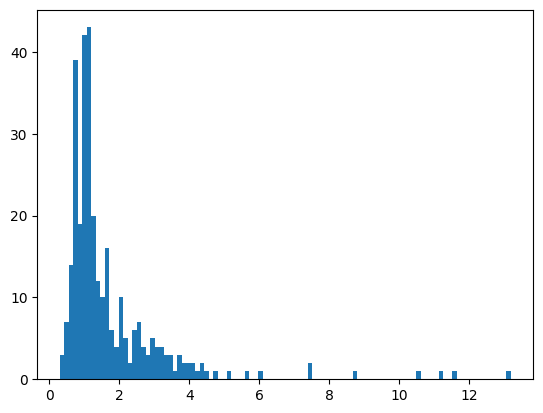

In [24]:
all_action_times = []

for key, gt_rec in gt_data['database'].items():
    for rec in gt_rec['annotations']:
        if rec['label'] == "CricketBowling":
            all_action_times.append(rec['segment'][1] - rec['segment'][0])
            if rec['segment'][1] - rec['segment'][0] > 10:
                print(key)

import matplotlib.pyplot as plt
plt.hist(all_action_times, bins=100)

## 其他

In [23]:
key, result = list(res_data['results'].items())[0]

gt = gt_data['database'][key]

KeyError: 'FPJ9D'

In [20]:
key, list(sorted(filter(lambda x: x['score'] > 0.2, result), key=lambda x: x['segment'][0]))

('FPJ9D',
 [{'segment': [-0.0, 4.82],
   'label': 'Opening a closet/cabinet',
   'score': 0.205},
  {'segment': [21.69, 27.66],
   'label': 'Putting something on a table',
   'score': 0.2104},
  {'segment': [24.13, 31.94],
   'label': 'Someone is going from standing to sitting',
   'score': 0.3298},
  {'segment': [25.51, 33.41], 'label': 'Sitting in a chair', 'score': 0.2708},
  {'segment': [25.51, 33.41], 'label': 'Sitting at a table', 'score': 0.2073},
  {'segment': [28.19, 33.42],
   'label': 'Putting on shoe/shoes',
   'score': 0.2289},
  {'segment': [28.19, 33.42],
   'label': 'Taking shoes from somewhere',
   'score': 0.2081}])

In [21]:
gt

{'duration': 33.42,
 'subset': 'testing',
 'annotations': [{'segment': [25.8, 34.0], 'label': 'Sitting in a chair'},
  {'segment': [24.4, 30.4],
   'label': 'Someone is going from standing to sitting'},
  {'segment': [25.3, 34.0], 'label': 'Sitting at a table'},
  {'segment': [25.3, 30.6],
   'label': 'Watching a laptop or something on a laptop'}]}